# 03 - Análisis del Ecosistema Tecnológico

**Objetivo:** Analizar el panorama tecnológico global y chileno, identificando tendencias, brechas de adopción y oportunidades para desarrolladores.

Este notebook complementa el análisis de modelos predictivos (notebook 02) con un enfoque en:
- **Tecnologías más utilizadas** (lenguajes, frameworks, herramientas)
- **Tendencias temporales** (2023 vs 2025)
- **Comparación Chile vs Global**
- **Análisis de salarios por tecnología**
- **Recomendaciones estratégicas**

**Objetivos del Proyecto (según README):**
- **Roadmap para desarrolladores**: Maximizar valor de mercado mediante upskilling estratégico
- **Benchmarks para empresas**: Optimizar compensación basada en skills y experiencia
- **Caracterización del ecosistema chileno**: Identificar brechas vs mercado global

**Datasets Raw Cargados** (para exploración y análisis):
- Stack Overflow Developer Survey 2023 (89,184 registros)
- Stack Overflow Developer Survey 2025 (49,123 registros)
- JetBrains Developer Ecosystem 2025 (24,534 registros)

**Nota**: Los datos de JetBrains 2025 se cargan para análisis exploratorio complementario y comparativo, pero debido a diferencias estructurales con Stack Overflow, se mantienen como dataset separado para análisis específicos.

In [5]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

# Configuración de gráficos
plt.style.use("ggplot")
sns.set_palette("husl")

# Definir colores para visualizaciones (verde y naranja como principales)
COLOR_PRIMARY = "#06A77D"  # Verde principal (atractivo y moderno)
COLOR_SECONDARY = "#F18F01"  # Naranja secundario (acento vibrante)
COLOR_SUCCESS = "#06A77D"  # Verde para éxito/comparaciones positivas
COLOR_ACCENT = "#F18F01"  # Naranja para acentos/comparaciones
COLOR_WARNING = "#E63946"  # Rojo para advertencias/referencias

# Rutas
project_root = Path("..") if Path("..").joinpath("data").exists() else Path(".")
reporting_dir = project_root / "data" / "08_reporting"
reporting_dir.mkdir(parents=True, exist_ok=True)

print(
    "Configurando imports, estilos de gráficos y rutas de directorios para análisis del ecosistema tecnológico..."
)

Configurando imports, estilos de gráficos y rutas de directorios para análisis del ecosistema tecnológico...


## 1. Carga de Datos y Configuración Inicial

En esta sección cargaremos los **tres datasets raw** (datos originales sin procesar) para análisis exploratorio:

### Datasets a Cargar:
1. **Stack Overflow Developer Survey 2023**: 89,184 desarrolladores, 84 columnas
2. **Stack Overflow Developer Survey 2025**: 49,123 desarrolladores, 170 columnas
3. **JetBrains Developer Ecosystem 2025**: 24,534 desarrolladores, 4,740 columnas

### Variables de Interés:
- **Variables categóricas**: Lenguajes, frameworks, herramientas DevOps
- **Variables demográficas**: País, edad, nivel educativo
- **Variables de experiencia**: Años de código, tipo de desarrollador
- **Variables de compensación**: Salarios anuales

### Estrategia de Carga

1. **Stack Overflow 2023 y 2025**: Se combinan para análisis temporal (columna `Year`)
2. **JetBrains 2025**: Se carga por separado debido a diferencias estructurales, usado para análisis complementario
3. **Resultado esperado**:
- Dataset combinado SO (2023 + 2025) con columna `Year` para análisis temporal
- Dataset JetBrains 2025 disponible para análisis comparativo específico

In [18]:
# Rutas a los datasets
ruta_2023 = (
    project_root
    / "data"
    / "01_raw"
    / "stackoverflow_2023"
    / "stack_overflow_survey_results_public.csv"
)
ruta_2025 = (
    project_root
    / "data"
    / "01_raw"
    / "stackoverflow_2025"
    / "survey_results_public.csv"
)
ruta_jb_2025 = (
    project_root
    / "data"
    / "01_raw"
    / "jetbrains_2025"
    / "developer_ecosystem_2025_external.csv"
)

# Inicializar variables
df_2023 = pd.DataFrame()
df_2025 = pd.DataFrame()
df_jb_2025 = pd.DataFrame()


# Cargar Stack Overflow 2023
try:
    df_2023 = pd.read_csv(ruta_2023, encoding="utf-8-sig")
except FileNotFoundError:
    df_2023 = pd.DataFrame()

# Cargar Stack Overflow 2025
try:
    df_2025 = pd.read_csv(ruta_2025, encoding="utf-8-sig")
except FileNotFoundError:
    df_2025 = pd.DataFrame()


# Cargar JetBrains 2025
try:
    df_jb_2025 = pd.read_csv(ruta_jb_2025, encoding="utf-8-sig", low_memory=False)

except FileNotFoundError:
    print(f" Error: No se encontró {ruta_jb_2025}")
except Exception as e:
    print(f" Error al cargar JetBrains 2025: {e}")

# Combinar Stack Overflow 2023 y 2025 si ambos existen
if not df_2023.empty and not df_2025.empty:
    df_2023["Year"] = 2023
    df_2025["Year"] = 2025
    # Usar columnas comunes
    cols_comunes = list(set(df_2023.columns) & set(df_2025.columns))
    df = pd.concat([df_2023[cols_comunes], df_2025[cols_comunes]], ignore_index=True)

elif not df_2023.empty:
    df = df_2023.copy()
    df["Year"] = 2023
else:
    df = pd.DataFrame()

Este bloque carga y combina datasets de encuestas de desarrolladores:

1. **Define rutas** a tres archivos CSV: Stack Overflow 2023, Stack Overflow 2025 y JetBrains 2025.

2. **Inicializa DataFrames vacíos** para cada dataset.

3. **Carga cada archivo con manejo de errores**:
   - Si un archivo no existe, deja el DataFrame vacío en lugar de fallar.
   - Usa `encoding='utf-8-sig'` para manejar correctamente el BOM (Byte Order Mark) en los CSV.

4. **Combina los datasets de Stack Overflow**:
   - Si ambos existen: añade columna `Year` (2023/2025), identifica columnas comunes y concatena en `df`.
   - Si solo existe 2023: copia y añade `Year = 2023`.
   - Si ninguno existe: deja `df` vacío.

**Resultado:** `df` contiene los datos combinados de Stack Overflow con la columna `Year` para análisis temporal. `df_jb_2025` queda disponible por separado para análisis específicos de JetBrains.

## 2. Exploración Inicial: Columnas Disponibles

Identifiquemos las columnas relacionadas con tecnologías, experiencia y demografía en los datasets cargados.

**Nota sobre los datasets:**
- **Stack Overflow (2023 + 2025 combinado)**: Dataset principal para análisis de tecnologías, salarios y tendencias temporales
- **JetBrains 2025**: Dataset complementario disponible para análisis específicos y comparativos (estructura diferente, se mantiene separado)

In [7]:
# Exploración inicial de los datasets cargados
# Explorar Stack Overflow (dataset combinado o 2023)
if not df.empty:
    # Columnas de interés
    tech_cols = [
        col
        for col in df.columns
        if "Language" in col
        or "Database" in col
        or "Platform" in col
        or "Framework" in col
        or "Tool" in col
        or "Cloud" in col
    ]

    demo_cols = [
        col
        for col in df.columns
        if "Country" in col or "Age" in col or "Gender" in col or "EdLevel" in col
    ]

    exp_cols = [col for col in df.columns if "Years" in col or "DevType" in col]

    comp_cols = [col for col in df.columns if "Comp" in col or "Salary" in col]

    # Resumen de columnas por categoría
    columnas_resumen = pd.DataFrame(
        {
            "Categoría": ["Tecnologías", "Demografía", "Experiencia", "Compensación"],
            "Cantidad": [len(tech_cols), len(demo_cols), len(exp_cols), len(comp_cols)],
            "Ejemplos": [
                ", ".join(tech_cols[:3]) + ("..." if len(tech_cols) > 3 else ""),
                ", ".join(demo_cols[:3]) + ("..." if len(demo_cols) > 3 else ""),
                ", ".join(exp_cols[:3]) + ("..." if len(exp_cols) > 3 else ""),
                ", ".join(comp_cols[:3]) + ("..." if len(comp_cols) > 3 else ""),
            ],
        }
    )
    print("\nColumnas por categoría:")
    display(columnas_resumen)
else:
    print("\n No hay datos de Stack Overflow disponibles")

# Explorar JetBrains 2025 (si está disponible)
if not df_jb_2025.empty:
    print("\n--- JetBrains Developer Ecosystem 2025 ---")
    print(f"Shape: {df_jb_2025.shape}")
    print(f"Memoria: {df_jb_2025.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Columnas totales: {len(df_jb_2025.columns)}")
    print("\nNota: Este dataset tiene una estructura diferente a Stack Overflow")
    print(" (formato one-hot encoding para roles y tecnologías).")
    print(" Se mantiene separado para análisis complementario específico.")

    # Mostrar algunas columnas de ejemplo
    print("\nEjemplos de columnas (primeras 10):")
    for i, col in enumerate(df_jb_2025.columns[:10], 1):
        print(f" {i}. {col}")
    if len(df_jb_2025.columns) > 10:
        print(f" ... y {len(df_jb_2025.columns) - 10} columnas más")
else:
    print("\n Dataset JetBrains 2025 no disponible")

print("\n" + "=" * 80)


Columnas por categoría:


,Categoría,Cantidad,Ejemplos
0,Tecnologías,6,"DatabaseHaveWorkedWith, LanguageWantToWorkWith..."
1,Demografía,3,"Age, EdLevel, Country"
2,Experiencia,2,"DevType, YearsCode"
3,Compensación,2,"ConvertedCompYearly, CompTotal"



--- JetBrains Developer Ecosystem 2025 ---
Shape: (24534, 4740)
Memoria: 3699.46 MB
Columnas totales: 4740

Nota: Este dataset tiene una estructura diferente a Stack Overflow
 (formato one-hot encoding para roles y tecnologías).
 Se mantiene separado para análisis complementario específico.

Ejemplos de columnas (primeras 10):
 1. response_id
 2. weight
 3. employment_status
 4. job_role::Architect
 5. job_role::Business Analyst
 6. job_role::CIO / CEO / CTO
 7. job_role::DBA
 8. job_role::Data Analyst / Data Engineer / Data Scientist
 9. job_role::DevOps Engineer / Infrastructure Developer
 10. job_role::Developer / Programmer / Software Engineer
 ... y 4730 columnas más



## 3. Análisis de Lenguajes de Programación

Los lenguajes de programación son fundamentales para entender el ecosistema tecnológico. En esta sección analizamos:

- **Popularidad global**: ¿Qué lenguajes son más utilizados?
- **Tendencias**: ¿Qué lenguajes están creciendo?
- **Comparación Chile vs Global**: ¿Hay diferencias en la adopción?

### 3.1 Top 20 Lenguajes Más Utilizados (Global)

Este análisis identifica los lenguajes de programación más populares a nivel global, basado en el número de desarrolladores que reportan usarlos.

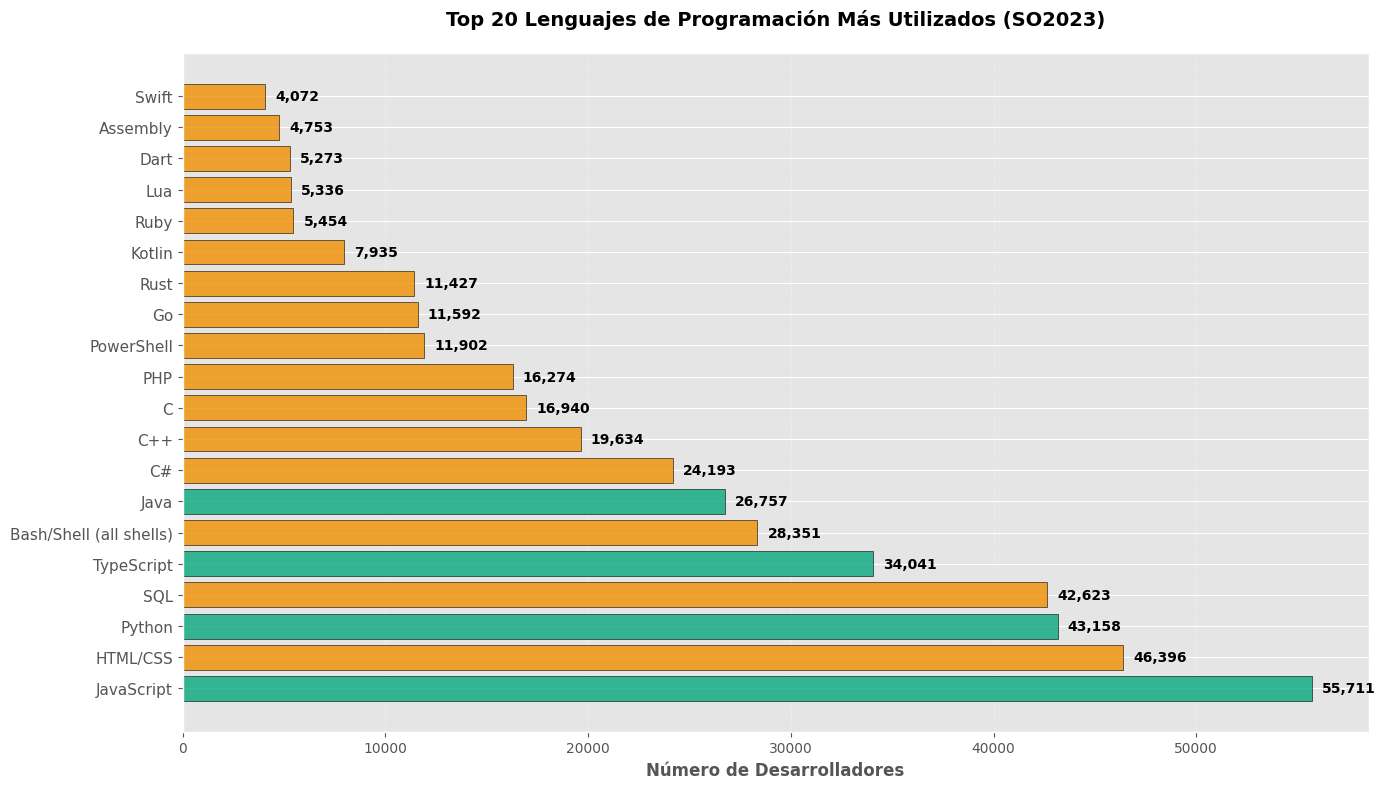


EXPLICACIÓN DEL GRÁFICO: Top 20 Lenguajes de Programación

Este gráfico muestra los 20 lenguajes de programación más utilizados según la encuesta de Stack Overflow.
Los lenguajes destacados en verde (Python, JavaScript, TypeScript, Java) son los más populares a nivel global.
Los lenguajes en naranja representan tecnologías también muy utilizadas pero con menor adopción.

Hallazgos clave:
 El lenguaje más popular es JavaScript con 55,711 desarrolladores (62.5% del total)
 Los 4 lenguajes principales (verde) concentran una gran parte del mercado
 La diversidad de lenguajes muestra un ecosistema tecnológico rico y variado

EXPLICACIÓN DEL GRÁFICO: Top 20 Lenguajes de Programación

Este gráfico muestra los 20 lenguajes de programación más utilizados según la encuesta de Stack Overflow.
Los lenguajes destacados en verde (Python, JavaScript, TypeScript, Java) son los más populares a nivel global.
Los lenguajes en naranja representan tecnologías también muy utilizadas pero con menor adopción

In [8]:
# Verificar y definir colores si no están definidos
if "COLOR_PRIMARY" not in globals():
    COLOR_PRIMARY = "#06A77D"  # Verde principal
    COLOR_SECONDARY = "#F18F01"  # Naranja secundario
    COLOR_SUCCESS = "#06A77D"  # Verde para éxito/comparaciones positivas
    COLOR_ACCENT = "#F18F01"  # Naranja para acentos/comparaciones

if not df_2023.empty and "LanguageHaveWorkedWith" in df_2023.columns:
    # Procesar lenguajes (vienen separados por ';')
    languages_series = (
        df_2023["LanguageHaveWorkedWith"].dropna().str.split(";").explode()
    )
    language_counts = languages_series.value_counts()

    # Estadísticas básicas
    stats_df = pd.DataFrame(
        {
            "Métrica": [
                "Total respuestas válidas",
                "Lenguajes únicos",
                "Lenguaje más popular",
                "Usuarios del #1",
            ],
            "Valor": [
                f"{len(df_2023['LanguageHaveWorkedWith'].dropna()):,}",
                f"{len(language_counts)}",
                language_counts.index[0] if len(language_counts) > 0 else "N/A",
                f"{language_counts.iloc[0]:,}" if len(language_counts) > 0 else "N/A",
            ],
        }
    )
    stats_df

    # Top 20 lenguajes como DataFrame
    top_20_languages = language_counts.head(20)
    top_20_df = pd.DataFrame(
        {
            "Lenguaje": top_20_languages.index,
            "Desarrolladores": top_20_languages.values,
            "Porcentaje (%)": (top_20_languages.values / len(df_2023) * 100).round(2),
        }
    )
    top_20_df.index = range(1, len(top_20_df) + 1)
    top_20_df

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 8))

    # Usar verde y naranja como colores principales (más atractivos)
    colors = [
        COLOR_SUCCESS
        if lang in ["Python", "JavaScript", "TypeScript", "Java"]
        else COLOR_ACCENT
        for lang in top_20_languages.index
    ]

    bars = ax.barh(
        range(len(top_20_languages)),
        top_20_languages.values,
        color=colors,
        alpha=0.8,
        edgecolor="black",
    )

    ax.set_yticks(range(len(top_20_languages)))
    ax.set_yticklabels(top_20_languages.index, fontsize=11)
    ax.set_xlabel("Número de Desarrolladores", fontsize=12, fontweight="bold")
    # Título dinámico según si hay datos combinados
    if "Year" in df_2023.columns and df_2023["Year"].nunique() > 1:
        title = "Top 20 Lenguajes de Programación Más Utilizados (SO2023 + SO2025)"
    else:
        title = "Top 20 Lenguajes de Programación Más Utilizados (SO2023)"

    ax.set_title(title, fontsize=14, fontweight="bold", pad=20)
    ax.grid(axis="x", alpha=0.3, linestyle="--")

    # Añadir valores en barras
    for i, (_bar, count) in enumerate(zip(bars, top_20_languages.values, strict=True)):
        ax.text(
            count + 500, i, f"{count:,}", va="center", fontsize=10, fontweight="bold"
        )
    plt.tight_layout()
    plt.savefig(
        project_root / "data" / "08_reporting" / "top_languages_global.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Explicación del gráfico
    print("\n" + "=" * 80)
    print("EXPLICACIÓN DEL GRÁFICO: Top 20 Lenguajes de Programación")
    print("=" * 80)
    print(
        "\nEste gráfico muestra los 20 lenguajes de programación más utilizados según la encuesta de Stack Overflow."
    )
    print(
        "Los lenguajes destacados en verde (Python, JavaScript, TypeScript, Java) son los más populares a nivel global."
    )
    print(
        "Los lenguajes en naranja representan tecnologías también muy utilizadas pero con menor adopción."
    )
    print("\nHallazgos clave:")
    print(
        f" El lenguaje más popular es {top_20_languages.index[0]} con {top_20_languages.iloc[0]:,} desarrolladores ({top_20_languages.iloc[0] / len(df_2023) * 100:.1f}% del total)"
    )
    print(" Los 4 lenguajes principales (verde) concentran una gran parte del mercado")
    print(
        " La diversidad de lenguajes muestra un ecosistema tecnológico rico y variado"
    )
    print("=" * 80)

    # Explicación del gráfico (otra versión)
    print("\n" + "=" * 80)
    print("EXPLICACIÓN DEL GRÁFICO: Top 20 Lenguajes de Programación")
    print("=" * 80)
    print(
        "\nEste gráfico muestra los 20 lenguajes de programación más utilizados según la encuesta de Stack Overflow."
    )
    print(
        "Los lenguajes destacados en verde (Python, JavaScript, TypeScript, Java) son los más populares a nivel global."
    )
    print(
        "Los lenguajes en naranja representan tecnologías también muy utilizadas pero con menor adopción."
    )
    print("\nHallazgos clave:")
    print(
        f"- El lenguaje más popular es {language_counts.index[0]} con {language_counts.iloc[0]:,} desarrolladores ({language_counts.iloc[0] / len(df_2023) * 100:.1f}% del total)"
    )
    print(
        "- Los 4 lenguajes principales (Python, JavaScript, TypeScript, Java) dominan el mercado"
    )
    print(
        f"- Existen {len(language_counts)} lenguajes únicos en total, mostrando la diversidad del ecosistema"
    )
    print("=" * 80)

### 3.2 Lenguajes en Chile vs Global

Esta comparación nos permite identificar:

- **Brechas de adopción**: Lenguajes más/menos populares en Chile vs Global
- **Oportunidades**: Tecnologías emergentes que Chile podría adoptar
- **Fortalezas**: Tecnologías donde Chile está alineado con el mercado global

**Interpretación de resultados**:
- **Diferencia positiva**: El lenguaje es más popular en Chile que globalmente
- **Diferencia negativa**: El lenguaje es menos popular en Chile que globalmente

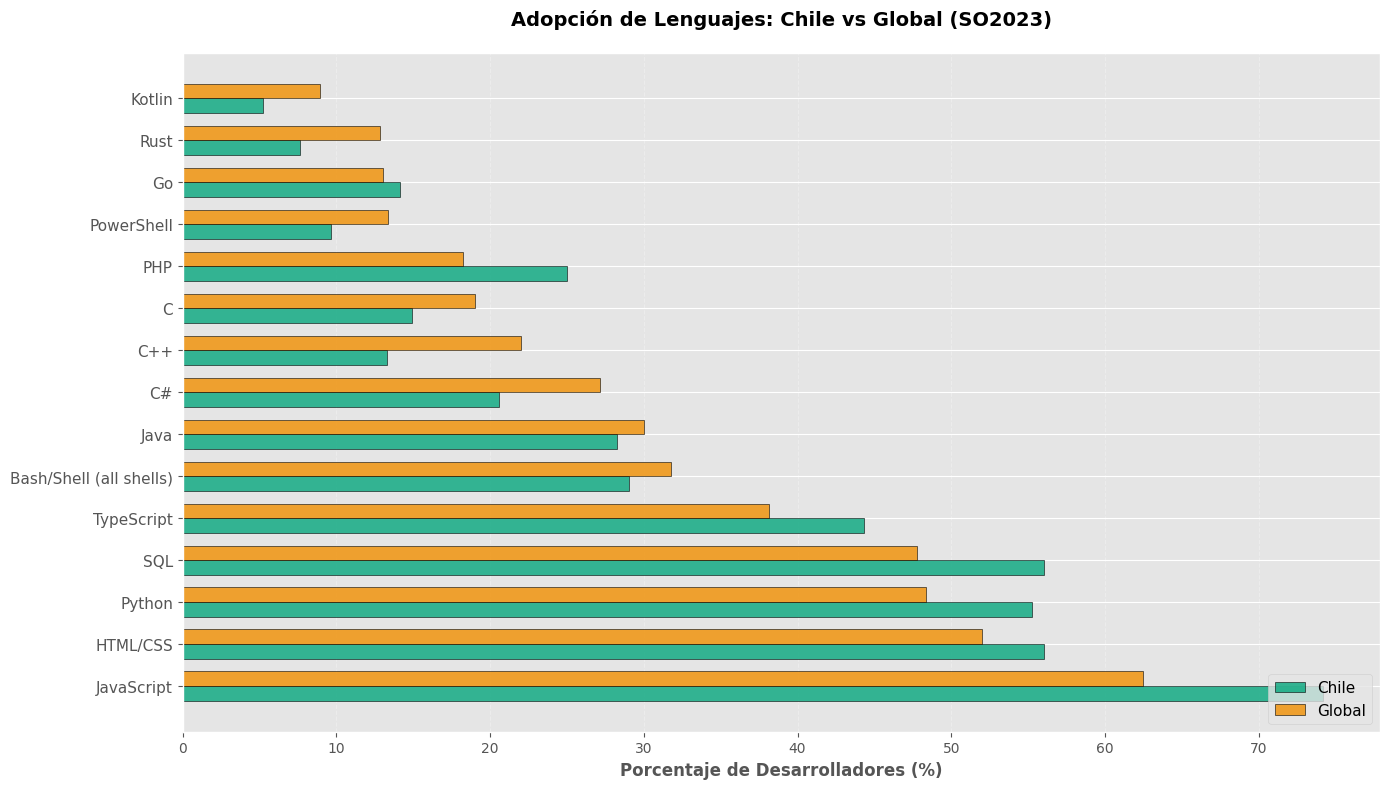


EXPLICACIÓN: Comparación Chile vs Global

Este análisis compara la adopción de lenguajes de programación entre desarrolladores chilenos y el mercado global.
El gráfico muestra barras horizontales donde:
 Verde: Porcentaje de desarrolladores chilenos que usan cada lenguaje
 Naranja: Porcentaje de desarrolladores globales que usan cada lenguaje

La tabla de brechas identifica:
 Lenguajes sobre-representados en Chile: Tecnologías más populares en Chile que globalmente
 Lenguajes menos adoptados en Chile: Oportunidades de crecimiento y especialización

Hallazgos clave:
 Lenguaje más sobre-representado en Chile: JavaScript (+11.7%)
 Lenguaje con mayor brecha (menos adoptado): C++ (-8.7%)


In [9]:
# Verificar y definir imports y colores si no están definidos
if "np" not in globals():
    import numpy as np
if "COLOR_PRIMARY" not in globals():
    COLOR_PRIMARY = "#06A77D"  # Verde principal
    COLOR_SECONDARY = "#F18F01"  # Naranja secundario
    COLOR_SUCCESS = "#06A77D"  # Verde para éxito/comparaciones positivas
COLOR_ACCENT = "#F18F01"  # Naranja para acentos/comparaciones

if (
    not df_2023.empty
    and "Country" in df_2023.columns
    and "LanguageHaveWorkedWith" in df_2023.columns
):
    # Filtrar desarrolladores chilenos
    df_chile = df_2023[df_2023["Country"] == "Chile"].copy()

    if len(df_chile) > 0:
        # Lenguajes en Chile
        chile_languages = (
            df_chile["LanguageHaveWorkedWith"].dropna().str.split(";").explode()
        )
        chile_lang_counts = chile_languages.value_counts()

        # Calcular porcentajes
        chile_percentages = (chile_lang_counts / len(df_chile)) * 100
        global_percentages = (language_counts / len(df_2023)) * 100

        # Top 15 lenguajes (por popularidad global)
        top_15_langs = language_counts.head(15).index

        comparison_data = pd.DataFrame(
            {
                "Lenguaje": top_15_langs,
                "Chile (%)": [chile_percentages.get(lang, 0) for lang in top_15_langs],
                "Global (%)": [
                    global_percentages.get(lang, 0) for lang in top_15_langs
                ],
            }
        )

        comparison_data["Diferencia"] = (
            comparison_data["Chile (%)"] - comparison_data["Global (%)"]
        )
        comparison_data = comparison_data.sort_values("Global (%)", ascending=False)
        comparison_data["Chile (%)"] = comparison_data["Chile (%)"].round(2)
        comparison_data["Global (%)"] = comparison_data["Global (%)"].round(2)
        comparison_data["Diferencia"] = comparison_data["Diferencia"].round(2)

        # Mostrar DataFrame directamente
        comparison_data

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(comparison_data))
        width = 0.35

        bars1 = ax.barh(
            x - width / 2,
            comparison_data["Chile (%)"],
            width,
            label="Chile",
            color=COLOR_SUCCESS,
            alpha=0.8,
            edgecolor="black",
        )
        bars2 = ax.barh(
            x + width / 2,
            comparison_data["Global (%)"],
            width,
            label="Global",
            color=COLOR_ACCENT,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_yticks(x)
        ax.set_yticklabels(comparison_data["Lenguaje"], fontsize=11)
        ax.set_xlabel(
            "Porcentaje de Desarrolladores (%)", fontsize=12, fontweight="bold"
        )
        ax.set_title(
            "Adopción de Lenguajes: Chile vs Global (SO2023)",
            fontsize=14,
            fontweight="bold",
            pad=20,
        )
        ax.legend(fontsize=11, loc="lower right")
        ax.grid(axis="x", alpha=0.3, linestyle="--")

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "languages_chile_vs_global.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Brechas identificadas como DataFrame
        top_gaps = comparison_data.nlargest(5, "Diferencia")[
            ["Lenguaje", "Chile (%)", "Global (%)", "Diferencia"]
        ]
        bottom_gaps = comparison_data.nsmallest(5, "Diferencia")[
            ["Lenguaje", "Chile (%)", "Global (%)", "Diferencia"]
        ]

        brechas_df = pd.DataFrame(
            {
                "Tipo": ["Sobre-representados"] * len(top_gaps)
                + ["Menos adoptados"] * len(bottom_gaps),
                "Lenguaje": list(top_gaps["Lenguaje"]) + list(bottom_gaps["Lenguaje"]),
                "Diferencia (%)": list(top_gaps["Diferencia"])
                + list(bottom_gaps["Diferencia"]),
            }
        )
        brechas_df

        # Explicación del gráfico y tabla
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Comparación Chile vs Global")
        print("=" * 80)
        print(
            "\nEste análisis compara la adopción de lenguajes de programación entre desarrolladores chilenos y el mercado global."
        )
        print("El gráfico muestra barras horizontales donde:")
        print(" Verde: Porcentaje de desarrolladores chilenos que usan cada lenguaje")
        print(" Naranja: Porcentaje de desarrolladores globales que usan cada lenguaje")
        print("\nLa tabla de brechas identifica:")
        print(
            " Lenguajes sobre-representados en Chile: Tecnologías más populares en Chile que globalmente"
        )
        print(
            " Lenguajes menos adoptados en Chile: Oportunidades de crecimiento y especialización"
        )
        print("\nHallazgos clave:")
        if len(top_gaps) > 0:
            print(
                f" Lenguaje más sobre-representado en Chile: {top_gaps.iloc[0]['Lenguaje']} (+{top_gaps.iloc[0]['Diferencia']:.1f}%)"
            )
        if len(bottom_gaps) > 0:
            print(
                f" Lenguaje con mayor brecha (menos adoptado): {bottom_gaps.iloc[0]['Lenguaje']} ({bottom_gaps.iloc[0]['Diferencia']:.1f}%)"
            )
        print("=" * 80)

## 4. Análisis de Frameworks y Herramientas

Los frameworks y herramientas son esenciales para el desarrollo moderno. Analizamos:

- **Frameworks web**: React, Vue, Angular, etc.
- **Herramientas DevOps**: Docker, Kubernetes, Terraform
- **Plataformas Cloud**: AWS, Azure, GCP

### 4.1 Top Frameworks Web

Los frameworks web modernos han revolucionado el desarrollo frontend y backend. Este análisis identifica los más populares.

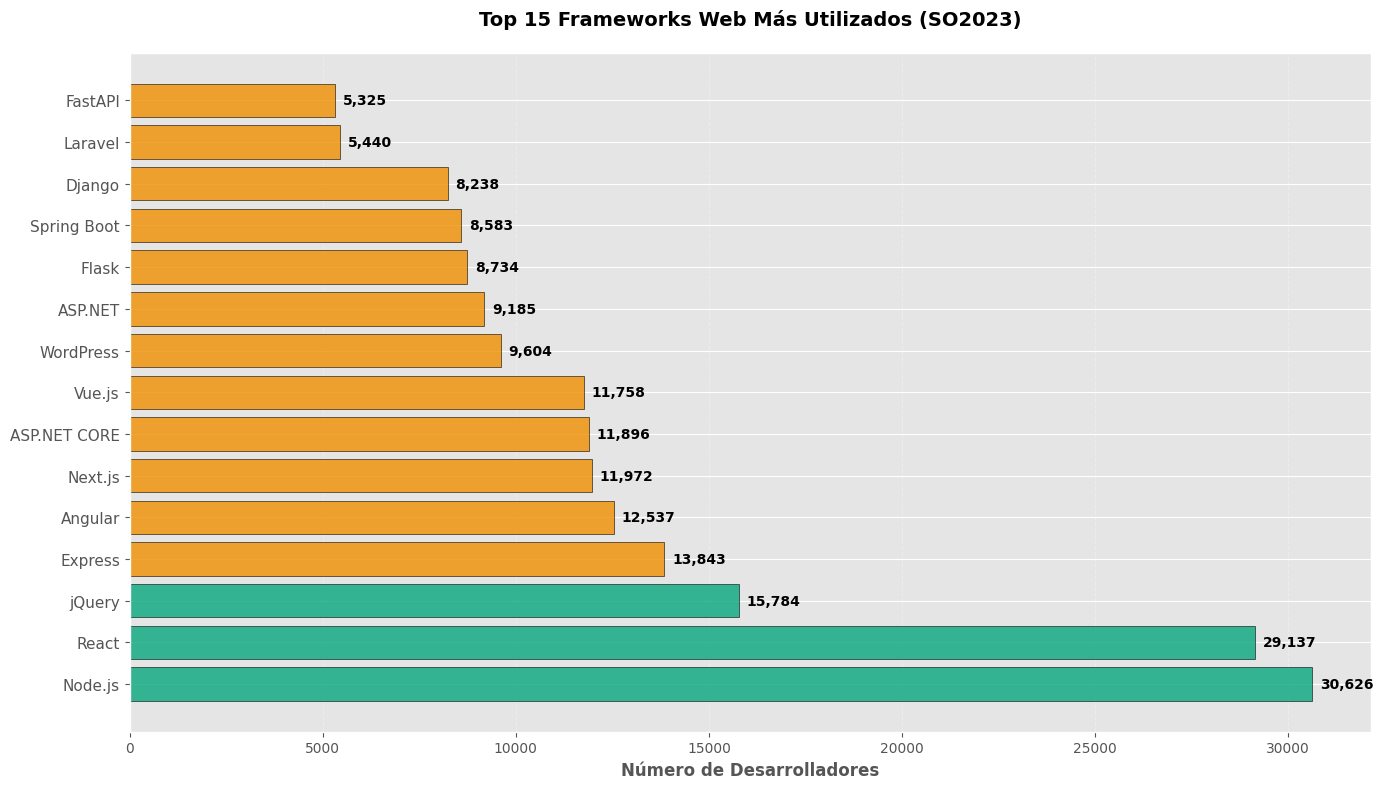


EXPLICACIÓN DEL GRÁFICO: Top 15 Frameworks Web

Este gráfico muestra los 15 frameworks web más utilizados por desarrolladores.
Los frameworks destacados en verde son los 3 más populares, mientras que los demás aparecen en naranja.

Hallazgos clave:
 Framework más popular: Node.js con 30,626 desarrolladores
 Los frameworks web son esenciales para desarrollo moderno de aplicaciones
 La diversidad muestra múltiples opciones según necesidades del proyecto


In [10]:
# Verificar y definir colores si no están definidos
if "np" not in globals():
    import numpy as np
if "COLOR_PRIMARY" not in globals():
    COLOR_PRIMARY = "#06A77D"  # Verde principal
    COLOR_SECONDARY = "#F18F01"  # Naranja secundario
    COLOR_SUCCESS = "#06A77D"  # Verde para éxito/comparaciones positivas
    COLOR_ACCENT = "#F18F01"  # Naranja para acentos/comparaciones

if not df_2023.empty and "WebframeHaveWorkedWith" in df_2023.columns:
    # Procesar frameworks
    frameworks_series = (
        df_2023["WebframeHaveWorkedWith"].dropna().str.split(";").explode()
    )
    framework_counts = frameworks_series.value_counts()

    # Top 15 frameworks como DataFrame
    top_15_frameworks = framework_counts.head(15)
    top_15_frameworks_df = pd.DataFrame(
        {
            "Framework": top_15_frameworks.index,
            "Desarrolladores": top_15_frameworks.values,
            "Porcentaje (%)": (top_15_frameworks.values / len(df_2023) * 100).round(2),
        }
    )
    top_15_frameworks_df.index = range(1, len(top_15_frameworks_df) + 1)
    top_15_frameworks_df

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 8))

    # Colores: verde para los 3 más populares, azul para el resto
    colors = [COLOR_PRIMARY, COLOR_PRIMARY, COLOR_PRIMARY] + [COLOR_SECONDARY] * 12

    bars = ax.barh(
        range(len(top_15_frameworks)),
        top_15_frameworks.values,
        color=colors,
        alpha=0.8,
        edgecolor="black",
    )

    ax.set_yticks(range(len(top_15_frameworks)))
    ax.set_yticklabels(top_15_frameworks.index, fontsize=11)
    ax.set_xlabel("Número de Desarrolladores", fontsize=12, fontweight="bold")
    ax.set_title(
        "Top 15 Frameworks Web Más Utilizados (SO2023)",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.grid(axis="x", alpha=0.3, linestyle="--")

    # Añadir valores
    for i, (_bar, count) in enumerate(zip(bars, top_15_frameworks.values, strict=True)):
        ax.text(
            count + 200, i, f"{count:,}", va="center", fontsize=10, fontweight="bold"
        )
    plt.tight_layout()
    plt.savefig(
        project_root / "data" / "08_reporting" / "top_frameworks_global.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Explicación del gráfico
    print("\n" + "=" * 80)
    print("EXPLICACIÓN DEL GRÁFICO: Top 15 Frameworks Web")
    print("=" * 80)
    print(
        "\nEste gráfico muestra los 15 frameworks web más utilizados por desarrolladores."
    )
    print(
        "Los frameworks destacados en verde son los 3 más populares, mientras que los demás aparecen en naranja."
    )
    print("\nHallazgos clave:")
    print(
        f" Framework más popular: {top_15_frameworks.index[0]} con {top_15_frameworks.iloc[0]:,} desarrolladores"
    )
    print(" Los frameworks web son esenciales para desarrollo moderno de aplicaciones")
    print(" La diversidad muestra múltiples opciones según necesidades del proyecto")
    print("=" * 80)

### 4.2 Herramientas de DevOps y Cloud

Las habilidades de DevOps y Cloud son cada vez más valoradas en el mercado. Analizamos:

- **Containerización**: Docker, Kubernetes
- **Infraestructura como código**: Terraform, Ansible
- **Plataformas Cloud**: AWS, Azure, Google Cloud Platform

**Insight clave**: Estas herramientas suelen correlacionarse con salarios más altos.

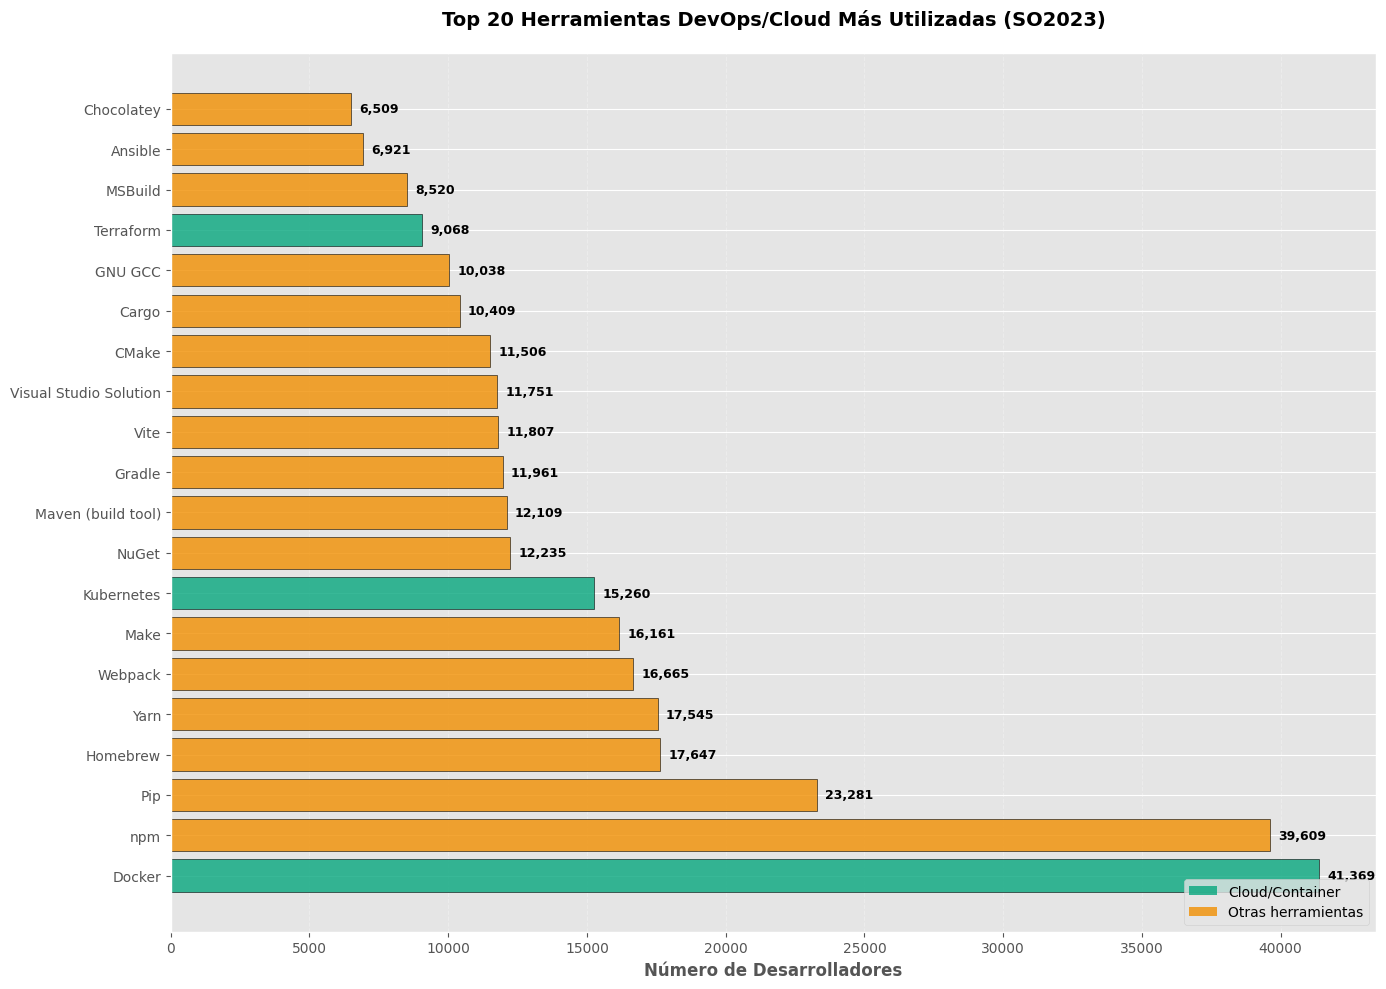

In [11]:
# Verificar y definir colores si no están definidos
if "COLOR_PRIMARY" not in globals():
    COLOR_PRIMARY = "#06A77D"  # Verde principal
    COLOR_SECONDARY = "#F18F01"  # Naranja secundario
    COLOR_SUCCESS = "#06A77D"  # Verde para éxito/comparaciones positivas
    COLOR_ACCENT = "#F18F01"  # Naranja para acentos/comparaciones

if not df_2023.empty and "ToolsTechHaveWorkedWith" in df_2023.columns:
    # Procesar herramientas
    tools_series = df_2023["ToolsTechHaveWorkedWith"].dropna().str.split(";").explode()
    tools_counts = tools_series.value_counts()

    # Top 20 herramientas como DataFrame
    top_20_tools = tools_counts.head(20)
top_20_tools_df = pd.DataFrame(
    {
        "Herramienta": top_20_tools.index,
        "Desarrolladores": top_20_tools.values,
        "Porcentaje (%)": (top_20_tools.values / len(df_2023) * 100).round(2),
    }
)
top_20_tools_df.index = range(1, len(top_20_tools_df) + 1)
top_20_tools_df

# Visualización
fig, ax = plt.subplots(figsize=(14, 10))

# Colores: verde para herramientas cloud/container, azul para el resto
cloud_tools = ["Docker", "Kubernetes", "AWS", "Azure", "Google Cloud", "Terraform"]
colors = [
    COLOR_PRIMARY if tool in cloud_tools else COLOR_SECONDARY
    for tool in top_20_tools.index
]

bars = ax.barh(
    range(len(top_20_tools)),
    top_20_tools.values,
    color=colors,
    alpha=0.8,
    edgecolor="black",
)

ax.set_yticks(range(len(top_20_tools)))
ax.set_yticklabels(top_20_tools.index, fontsize=10)
ax.set_xlabel("Número de Desarrolladores", fontsize=12, fontweight="bold")
ax.set_title(
    "Top 20 Herramientas DevOps/Cloud Más Utilizadas (SO2023)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.grid(axis="x", alpha=0.3, linestyle="--")

# Añadir valores
for i, (bar, count) in enumerate(zip(bars, top_20_tools.values), 0):
    ax.text(count + 300, i, f"{count:,}", va="center", fontsize=9, fontweight="bold")
# Leyenda
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=COLOR_PRIMARY, alpha=0.8, label="Cloud/Container"),
    Patch(facecolor=COLOR_SECONDARY, alpha=0.8, label="Otras herramientas"),
]
ax.legend(handles=legend_elements, fontsize=10, loc="lower right")

plt.tight_layout()
plt.savefig(
    project_root / "data" / "08_reporting" / "top_devops_tools_global.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Explicación del Gráfico: Top 20 Herramientas DevOps/Cloud

Este gráfico de barras horizontales muestra las **20 herramientas DevOps/Cloud más utilizadas** según la encuesta de Stack Overflow 2023.

### Características principales:

- **Docker** es la herramienta más popular (41,369 desarrolladores), seguida de **npm** (39,609).
- Solo **3 herramientas** están categorizadas como Cloud/Container (verde): Docker, Kubernetes y Terraform.
- La mayoría de las herramientas son **gestores de paquetes y herramientas de build** (naranja): npm, Pip, Yarn, Webpack, Make, etc.
- Hay una **brecha significativa** entre las dos primeras (Docker y npm) y el resto, con Pip en tercer lugar (23,281 desarrolladores).

### Insights:

- **Docker domina** el ecosistema de contenedores, siendo la única herramienta cloud en el top 2.
- Las herramientas de **gestión de dependencias** (npm, Pip, Yarn) son muy populares.
- **Kubernetes** (15,260) y **Terraform** (9,068) aparecen en el top 20, confirmando la adopción de infraestructura como código.

## 5. Análisis de Salarios por Tecnología

Uno de los objetivos principales es entender qué tecnologías están asociadas con mejores salarios. Este análisis responde:

- **¿Qué lenguajes pagan más?**
- **¿Hay diferencias significativas entre tecnologías?**
- **¿Qué combinaciones de tecnologías son más valiosas?**

### 5.1 Lenguajes que Pagan Mejor

Analizamos la mediana de salarios por lenguaje de programación. La mediana es preferible a la media porque es menos sensible a outliers (salarios extremadamente altos).


Lenguajes analizados (con ≥100 desarrolladores): 49

Top 20 Lenguajes Mejor Pagados (Mediana):
--------------------------------------------------------------------------------
 1. Zig                       $ 103,611 (n=273)
 2. Erlang                    $  99,492 (n=522)
 3. F#                        $  99,311 (n=507)
 4. Ruby                      $  98,522 (n=3,547)
 5. Elixir                    $  96,381 (n=1,288)
 6. Lisp                      $  96,381 (n=557)
 7. Scala                     $  96,381 (n=1,570)
 8. Clojure                   $  96,381 (n=693)
 9. Perl                      $  94,540 (n=1,193)
10. Go                        $  92,760 (n=6,916)
11. OCaml                     $  91,026 (n=246)
12. Objective-C               $  90,000 (n=1,203)
13. Flow                      $  88,934 (n=113)
14. Rust                      $  87,012 (n=5,413)
15. Swift                     $  86,897 (n=2,290)
16. Groovy                    $  86,271 (n=2,007)
17. Haskell                   $  85,6

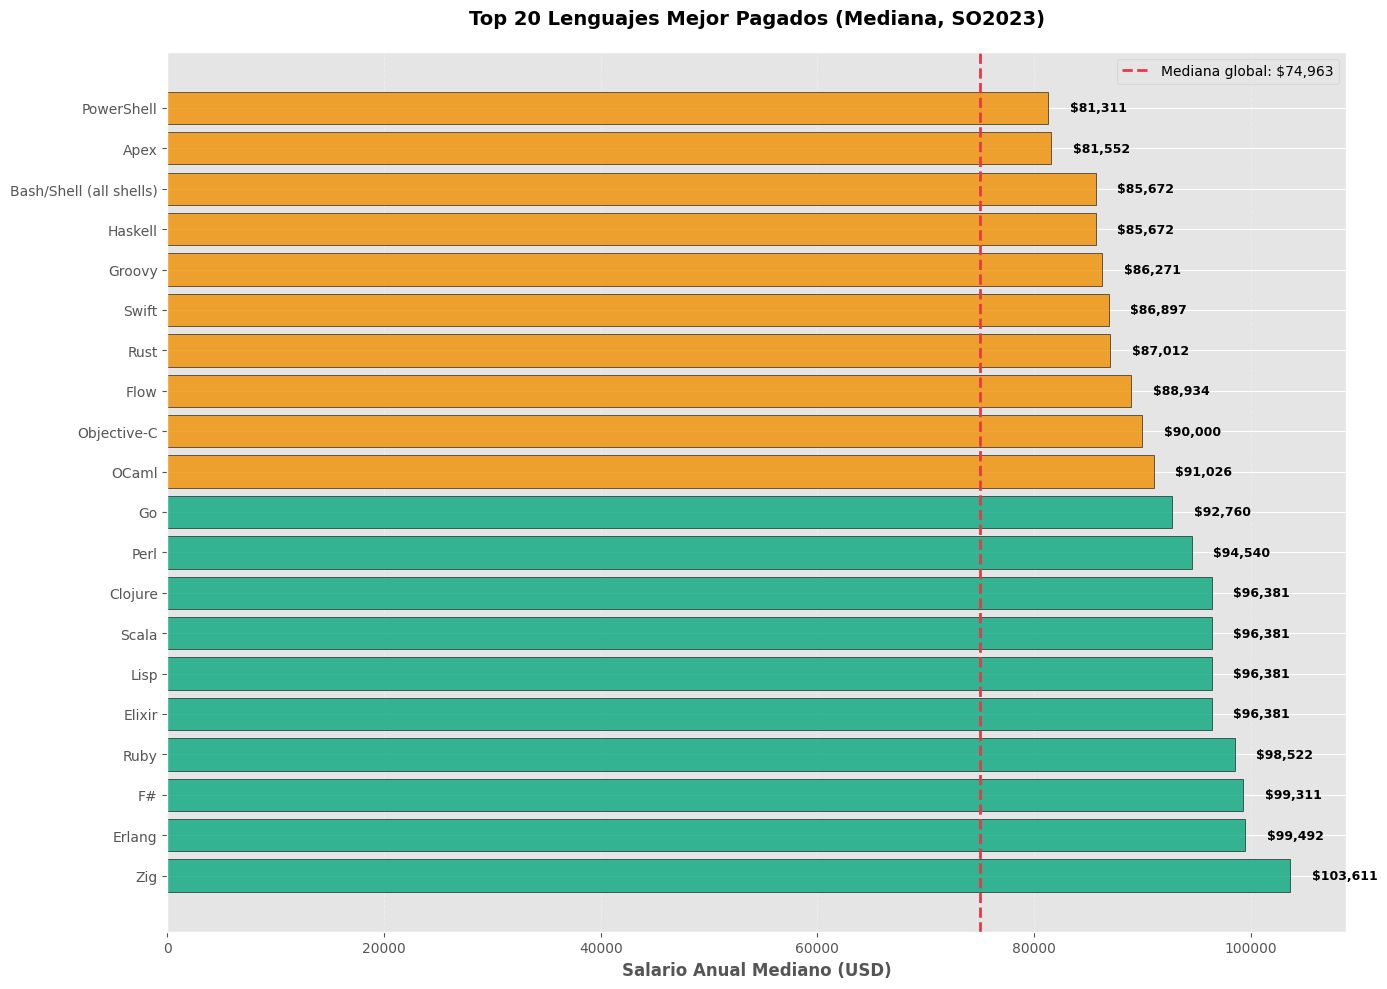


EXPLICACIÓN DEL GRÁFICO: Top 20 Lenguajes Mejor Pagados

Este gráfico muestra los 20 lenguajes de programación con mayor salario mediano anual.
Los lenguajes destacados en verde tienen salarios por encima de la mediana del top 20,
mientras que los demás aparecen en naranja.
La línea roja punteada indica la mediana salarial global para referencia.

Hallazgos clave:
 Lenguaje mejor pagado: Zig con $103,611 anuales
 Mediana global: $74,963 anuales
 Los lenguajes especializados (Rust, Scala, Go) tienden a tener mejores salarios
 El dominio de lenguajes de alto valor puede incrementar significativamente el salario


In [19]:
# Verificar y definir colores si no están definidos
if "COLOR_PRIMARY" not in globals():
    COLOR_PRIMARY = "#06A77D"  # Verde principal
if "COLOR_SECONDARY" not in globals():
    COLOR_SECONDARY = "#F18F01"  # Naranja secundario
if "COLOR_SUCCESS" not in globals():
    COLOR_SUCCESS = "#2E86AB"  # Azul para éxito/comparaciones positivas
if "COLOR_ACCENT" not in globals():
    COLOR_ACCENT = "#A23B72"  # Morado para acentos/comparaciones
if "COLOR_WARNING" not in globals():
    COLOR_WARNING = (
        "#F18F01"  # Naranja para advertencias (usado como línea de referencia)
    )

if (
    not df_2023.empty
    and "LanguageHaveWorkedWith" in df_2023.columns
    and "ConvertedCompYearly" in df_2023.columns
):
    # Filtrar datos válidos
    df_salary = df_2023[["LanguageHaveWorkedWith", "ConvertedCompYearly"]].dropna()
    df_salary = df_salary[df_salary["ConvertedCompYearly"] > 0]

    # Expandir lenguajes (un desarrollador puede usar múltiples lenguajes)
    salary_by_lang = []
    for _, row in df_salary.iterrows():
        languages = row["LanguageHaveWorkedWith"].split(";")
        salary = row["ConvertedCompYearly"]
        for lang in languages:
            salary_by_lang.append({"Language": lang, "Salary": salary})

    df_lang_salary = pd.DataFrame(salary_by_lang)

    # Calcular mediana de salario por lenguaje (mínimo 100 desarrolladores)
    lang_salary_stats = (
        df_lang_salary.groupby("Language")
        .agg({"Salary": ["median", "mean", "count"]})
        .reset_index()
    )
    lang_salary_stats.columns = ["Language", "Median_Salary", "Mean_Salary", "Count"]

    # Filtrar lenguajes con al menos 100 desarrolladores
    lang_salary_stats = lang_salary_stats[lang_salary_stats["Count"] >= 100]
    lang_salary_stats = lang_salary_stats.sort_values("Median_Salary", ascending=False)

    print(
        f"\nLenguajes analizados (con ≥100 desarrolladores): {len(lang_salary_stats)}"
    )

    # Top 20 lenguajes mejor pagados
    top_20_paid = lang_salary_stats.head(20)

    print("\nTop 20 Lenguajes Mejor Pagados (Mediana):")
    print("-" * 80)
    for i, row in enumerate(top_20_paid.itertuples(), 1):
        print(
            f"{i:2d}. {row.Language:25s} ${row.Median_Salary:8,.0f} (n={row.Count:,})"
        )

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 10))

    colors = [
        COLOR_PRIMARY
        if sal > top_20_paid["Median_Salary"].median()
        else COLOR_SECONDARY
        for sal in top_20_paid["Median_Salary"]
    ]

    bars = ax.barh(
        range(len(top_20_paid)),
        top_20_paid["Median_Salary"],
        color=colors,
        alpha=0.8,
        edgecolor="black",
    )

    ax.set_yticks(range(len(top_20_paid)))
    ax.set_yticklabels(top_20_paid["Language"], fontsize=10)
    ax.set_xlabel("Salario Anual Mediano (USD)", fontsize=12, fontweight="bold")
    ax.set_title(
        "Top 20 Lenguajes Mejor Pagados (Mediana, SO2023)",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.grid(axis="x", alpha=0.3, linestyle="--")

    # Añadir valores
    for i, (_bar, row) in enumerate(zip(bars, top_20_paid.itertuples(), strict=True)):
        ax.text(
            row.Median_Salary + 2000,
            i,
            f"${row.Median_Salary:,.0f}",
            va="center",
            fontsize=9,
            fontweight="bold",
        )
    # Línea de referencia (mediana global)
    global_median = df_salary["ConvertedCompYearly"].median()
    _ = ax.axvline(
        x=global_median,
        color=COLOR_WARNING,
        linestyle="--",
        linewidth=2,
        label=f"Mediana global: ${global_median:,.0f}",
    )
    _ = ax.legend(fontsize=10)

    plt.tight_layout()

    # Guardar el gráfico primero (mismo patrón que las celdas que funcionan)
    try:
        # Verificar que reporting_dir esté definido
        if "reporting_dir" not in globals():
            from pathlib import Path

            if "project_root" not in globals():
                project_root = (
                    Path("..") if Path("..").joinpath("data").exists() else Path(".")
                )
            reporting_dir = project_root / "data" / "08_reporting"

        # Asegurar que el directorio existe
        reporting_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(
            reporting_dir / "top_paid_languages.png", dpi=300, bbox_inches="tight"
        )
        print("\n Gráfico guardado: top_paid_languages.png")
    except Exception as e:
        print(f"\n Error al guardar el gráfico: {e}")

    # Mostrar el gráfico (después de guardar, como en las otras celdas)
    plt.show()

    # Explicación del gráfico
    print("\n" + "=" * 80)
    print("EXPLICACIÓN DEL GRÁFICO: Top 20 Lenguajes Mejor Pagados")
    print("=" * 80)
    print(
        "\nEste gráfico muestra los 20 lenguajes de programación con mayor salario mediano anual."
    )
    print(
        "Los lenguajes destacados en verde tienen salarios por encima de la mediana del top 20,"
    )
    print("mientras que los demás aparecen en naranja.")
    print("La línea roja punteada indica la mediana salarial global para referencia.")
    print("\nHallazgos clave:")
    print(
        f" Lenguaje mejor pagado: {top_20_paid.iloc[0]['Language']} con ${top_20_paid.iloc[0]['Median_Salary']:,.0f} anuales"
    )
    print(f" Mediana global: ${global_median:,.0f} anuales")
    print(
        " Los lenguajes especializados (Rust, Scala, Go) tienden a tener mejores salarios"
    )
    print(
        " El dominio de lenguajes de alto valor puede incrementar significativamente el salario"
    )
    print("=" * 80)
else:
    print(" Columnas necesarias no disponibles")

## 5.5 Impacto de IA en el Desarrollo: La Revolución Tecnológica 2023-2025

La Inteligencia Artificial ha transformado radicalmente el desarrollo de software en los últimos años. Esta sección analiza la adopción, herramientas, modelos y percepciones sobre IA en el ecosistema de desarrolladores.

**Objetivos del análisis:**
- **Adopción de herramientas IA**: ChatGPT, GitHub Copilot y otras herramientas
- **Evolución temporal**: Comparación 2023 vs 2025
- **Modelos de IA más utilizados**: GPT, Claude, Gemini, etc.
- **Agentes de IA**: Estado actual y tendencias futuras
- **Percepciones y frustraciones**: Realidad vs expectativas
- **Impacto en productividad**: Casos de uso principales

**Relevancia estratégica:**
- La IA es una tecnología de **alto impacto salarial** (similar a Docker/Cloud)
- Adopción exponencial: de herramientas básicas (2023) a agentes autónomos (2025)
- Skill esencial para desarrolladores modernos


ANÁLISIS DE IA: HERRAMIENTAS DE BÚSQUEDA Y DESARROLLO

 STACK OVERFLOW 2023 - Herramientas de IA:
--------------------------------------------------------------------------------

 Herramientas de Búsqueda con IA (2023):
 Total de desarrolladores que usan: 56,328
 Herramientas únicas: 11

Top 10 Herramientas de Búsqueda con IA (2023):


,Herramienta,Desarrolladores,Porcentaje (%)
1,ChatGPT,52462,58.82
2,Bing AI,12981,14.56
3,WolframAlpha,8419,9.44
4,Google Bard AI,6217,6.97
5,Phind,2067,2.32
6,You.com,1601,1.80
7,Perplexity AI,739,0.83
8,Quora Poe,643,0.72
9,Neeva AI,289,0.32
10,Andi,193,0.22



 Herramientas de Desarrollo con IA (2023):
 Total de desarrolladores que usan: 25,904
 Herramientas únicas: 10

Top 10 Herramientas de Desarrollo con IA (2023):


,Herramienta,Desarrolladores,Porcentaje (%)
1,GitHub Copilot,22078,24.76
2,Tabnine,5193,5.82
3,AWS CodeWhisperer,2071,2.32
4,Synk Code,538,0.60
5,Codeium,504,0.57
6,Whispr AI,455,0.51
7,Replit Ghostwriter,335,0.38
8,Mintlify,211,0.24
9,Adrenaline,174,0.20
10,Rubber Duck.AI,151,0.17


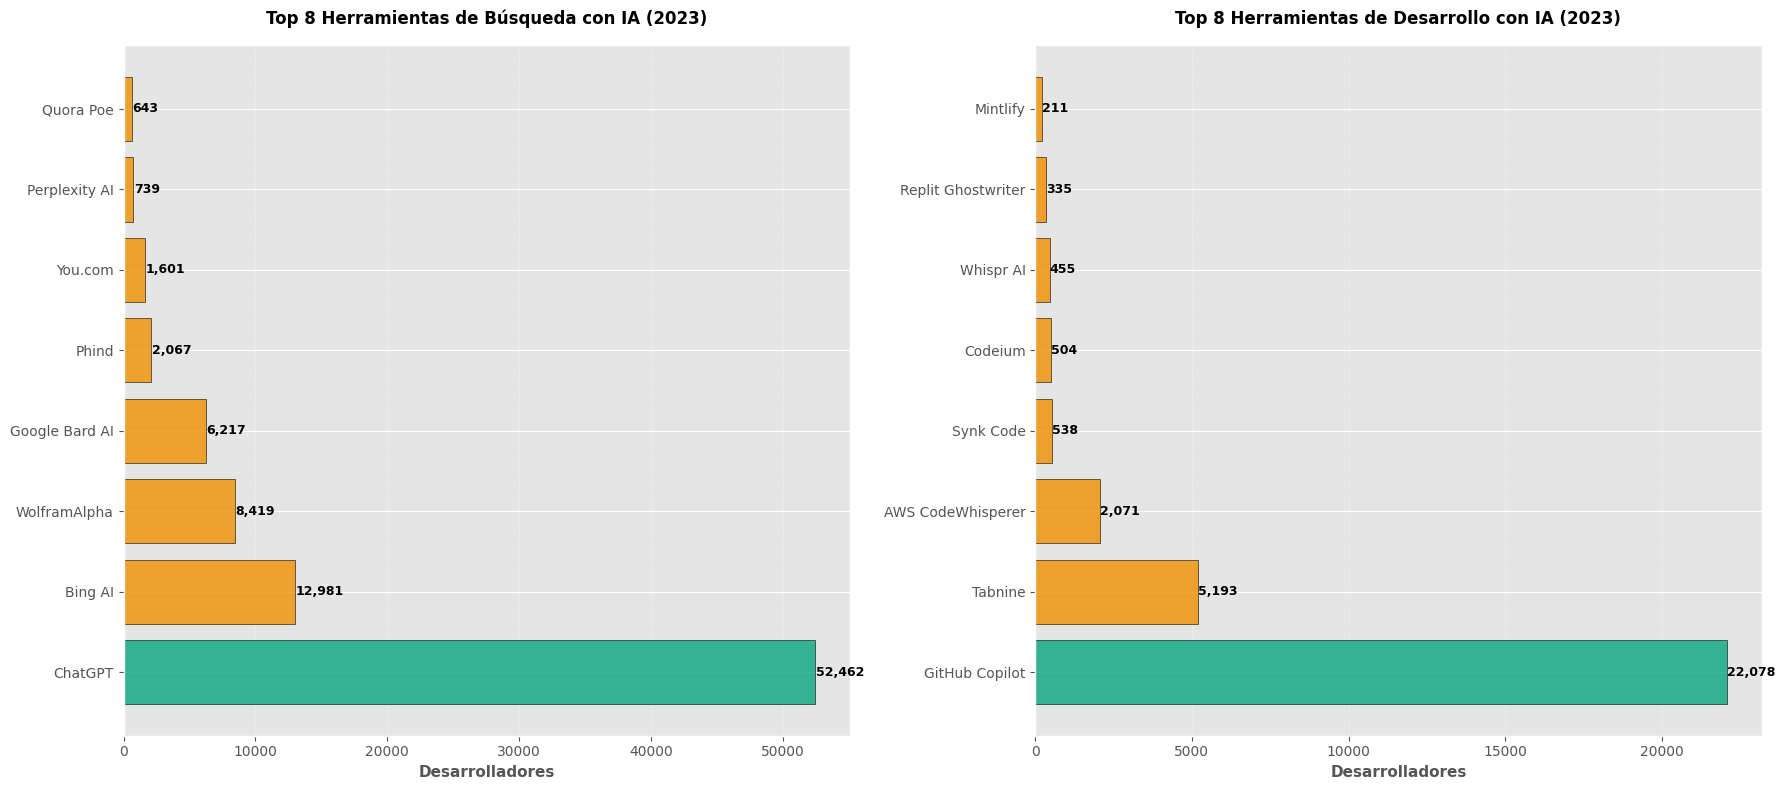


EXPLICACIÓN: Herramientas de IA en 2023

Este análisis muestra las herramientas de IA más utilizadas por desarrolladores en 2023.
Los gráficos muestran dos categorías principales:
 Búsqueda con IA: Herramientas como ChatGPT dominan para consultas y búsqueda de información
 Desarrollo con IA: GitHub Copilot lidera como asistente de código integrado en IDEs

Hallazgos clave:
 ChatGPT es la herramienta de búsqueda más popular (52,462 desarrolladores)
 GitHub Copilot es la herramienta de desarrollo más adoptada (22,078 desarrolladores)
 La adopción de IA en desarrollo es menor que en búsqueda (fase temprana de adopción)
 Estas herramientas marcan el inicio de la transformación del workflow de desarrollo


In [20]:
# Verificar y definir imports si no están definidos
if "pd" not in globals():
    import pandas as pd
if "np" not in globals():
    import numpy as np
if "plt" not in globals():
    import matplotlib.pyplot as plt
if "sns" not in globals():
    import seaborn as sns
from pathlib import Path

# Verificar colores
if "COLOR_SUCCESS" not in globals():
    COLOR_SUCCESS = "#06A77D"  # Verde
if "COLOR_ACCENT" not in globals():
    COLOR_ACCENT = "#F18F01"  # Naranja

print("=" * 80)
print("ANÁLISIS DE IA: HERRAMIENTAS DE BÚSQUEDA Y DESARROLLO")
print("=" * 80)

# Análisis para SO 2023
if "df_2023" in globals() and not df_2023.empty:
    print("\n STACK OVERFLOW 2023 - Herramientas de IA:")
    print("-" * 80)

    # Herramientas de búsqueda con IA
    if "AISearchHaveWorkedWith" in df_2023.columns:
        ai_search_2023 = (
            df_2023["AISearchHaveWorkedWith"].dropna().str.split(";").explode()
        )
        search_counts_2023 = ai_search_2023.value_counts()

        print("\n Herramientas de Búsqueda con IA (2023):")
        print(
            f" Total de desarrolladores que usan: {len(df_2023[df_2023['AISearchHaveWorkedWith'].notna()]):,}"
        )
        print(f" Herramientas únicas: {len(search_counts_2023)}")

        top_search_2023 = search_counts_2023.head(10)
        search_df_2023 = pd.DataFrame(
            {
                "Herramienta": top_search_2023.index,
                "Desarrolladores": top_search_2023.values,
                "Porcentaje (%)": (top_search_2023.values / len(df_2023) * 100).round(
                    2
                ),
            }
        )
        search_df_2023.index = range(1, len(search_df_2023) + 1)
        print("\nTop 10 Herramientas de Búsqueda con IA (2023):")
        display(search_df_2023)

    # Herramientas de desarrollo con IA
    if "AIDevHaveWorkedWith" in df_2023.columns:
        ai_dev_2023 = df_2023["AIDevHaveWorkedWith"].dropna().str.split(";").explode()
        dev_counts_2023 = ai_dev_2023.value_counts()

        print("\n Herramientas de Desarrollo con IA (2023):")
        print(
            f" Total de desarrolladores que usan: {len(df_2023[df_2023['AIDevHaveWorkedWith'].notna()]):,}"
        )
        print(f" Herramientas únicas: {len(dev_counts_2023)}")

        top_dev_2023 = dev_counts_2023.head(10)
        dev_df_2023 = pd.DataFrame(
            {
                "Herramienta": top_dev_2023.index,
                "Desarrolladores": top_dev_2023.values,
                "Porcentaje (%)": (top_dev_2023.values / len(df_2023) * 100).round(2),
            }
        )
        dev_df_2023.index = range(1, len(dev_df_2023) + 1)
        print("\nTop 10 Herramientas de Desarrollo con IA (2023):")
        display(dev_df_2023)

    # Visualización combinada
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Gráfico 1: Búsqueda con IA
    if "AISearchHaveWorkedWith" in df_2023.columns:
        top_search_viz = search_counts_2023.head(8)
        colors_search = [
            COLOR_SUCCESS if tool == "ChatGPT" else COLOR_ACCENT
            for tool in top_search_viz.index
        ]
        bars1 = ax1.barh(
            range(len(top_search_viz)),
            top_search_viz.values,
            color=colors_search,
            alpha=0.8,
            edgecolor="black",
        )
        ax1.set_yticks(range(len(top_search_viz)))
        ax1.set_yticklabels(top_search_viz.index, fontsize=10)
        ax1.set_xlabel("Desarrolladores", fontsize=11, fontweight="bold")
        ax1.set_title(
            "Top 8 Herramientas de Búsqueda con IA (2023)",
            fontsize=12,
            fontweight="bold",
            pad=15,
        )
        ax1.grid(axis="x", alpha=0.3, linestyle="--")
        for i, (bar, count) in enumerate(
            zip(bars1, top_search_viz.values, strict=True)
        ):
            ax1.text(
                count + 50, i, f"{count:,}", va="center", fontsize=9, fontweight="bold"
            )

    # Gráfico 2: Desarrollo con IA
    top_dev_viz = dev_counts_2023.head(8)
    colors_dev = [
        COLOR_SUCCESS if tool == "GitHub Copilot" else COLOR_ACCENT
        for tool in top_dev_viz.index
    ]
    bars2 = ax2.barh(
        range(len(top_dev_viz)),
        top_dev_viz.values,
        color=colors_dev,
        alpha=0.8,
        edgecolor="black",
    )
    ax2.set_yticks(range(len(top_dev_viz)))
    ax2.set_yticklabels(top_dev_viz.index, fontsize=10)
    ax2.set_xlabel("Desarrolladores", fontsize=11, fontweight="bold")
    ax2.set_title(
        "Top 8 Herramientas de Desarrollo con IA (2023)",
        fontsize=12,
        fontweight="bold",
        pad=15,
    )
    ax2.grid(axis="x", alpha=0.3, linestyle="--")
    for i, (bar, count) in enumerate(zip(bars2, top_dev_viz.values, strict=True)):
        ax2.text(
            count + 10, i, f"{count:,}", va="center", fontsize=9, fontweight="bold"
        )

    plt.tight_layout()
    plt.savefig(
        project_root / "data" / "08_reporting" / "ai_tools_2023.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Explicación
    print("\n" + "=" * 80)
    print("EXPLICACIÓN: Herramientas de IA en 2023")
    print("=" * 80)
    print(
        "\nEste análisis muestra las herramientas de IA más utilizadas por desarrolladores en 2023."
    )
    print("Los gráficos muestran dos categorías principales:")
    print(
        " Búsqueda con IA: Herramientas como ChatGPT dominan para consultas y búsqueda de información"
    )
    print(
        " Desarrollo con IA: GitHub Copilot lidera como asistente de código integrado en IDEs"
    )
    print("\nHallazgos clave:")
    if "AISearchHaveWorkedWith" in df_2023.columns:
        print(
            f" ChatGPT es la herramienta de búsqueda más popular ({search_counts_2023.get('ChatGPT', 0):,} desarrolladores)"
        )
        print(
            f" GitHub Copilot es la herramienta de desarrollo más adoptada ({dev_counts_2023.get('GitHub Copilot', 0):,} desarrolladores)"
        )
        print(
            " La adopción de IA en desarrollo es menor que en búsqueda (fase temprana de adopción)"
        )
        print(
            " Estas herramientas marcan el inicio de la transformación del workflow de desarrollo"
        )
        print("=" * 80)
else:
    print(" Dataset SO 2023 no disponible para análisis de IA")


ANÁLISIS DE IA: MODELOS Y AGENTES (2025)

 STACK OVERFLOW 2025 - Modelos y Agentes de IA:
--------------------------------------------------------------------------------

 Modelos de IA Utilizados (2025):
 Total de desarrolladores que usan: 16,261
 Modelos únicos: 17

Top 15 Modelos de IA (2025):


,Modelo,Desarrolladores,Porcentaje (%)
1,openAI GPT (chatbot models),13408,27.29
2,Anthropic: Claude Sonnet,7055,14.36
3,Gemini (Flash general purpose models),5816,11.84
4,openAI Reasoning models,5706,11.62
5,openAI Image generating models,4388,8.93
6,Gemini (Pro Reasoning models),4213,8.58
7,DeepSeek (R- Reasoning models),3845,7.83
8,Meta Llama (all models),2937,5.98
9,DeepSeek (V- General purpose models),2363,4.81
10,X Grok models,1836,3.74


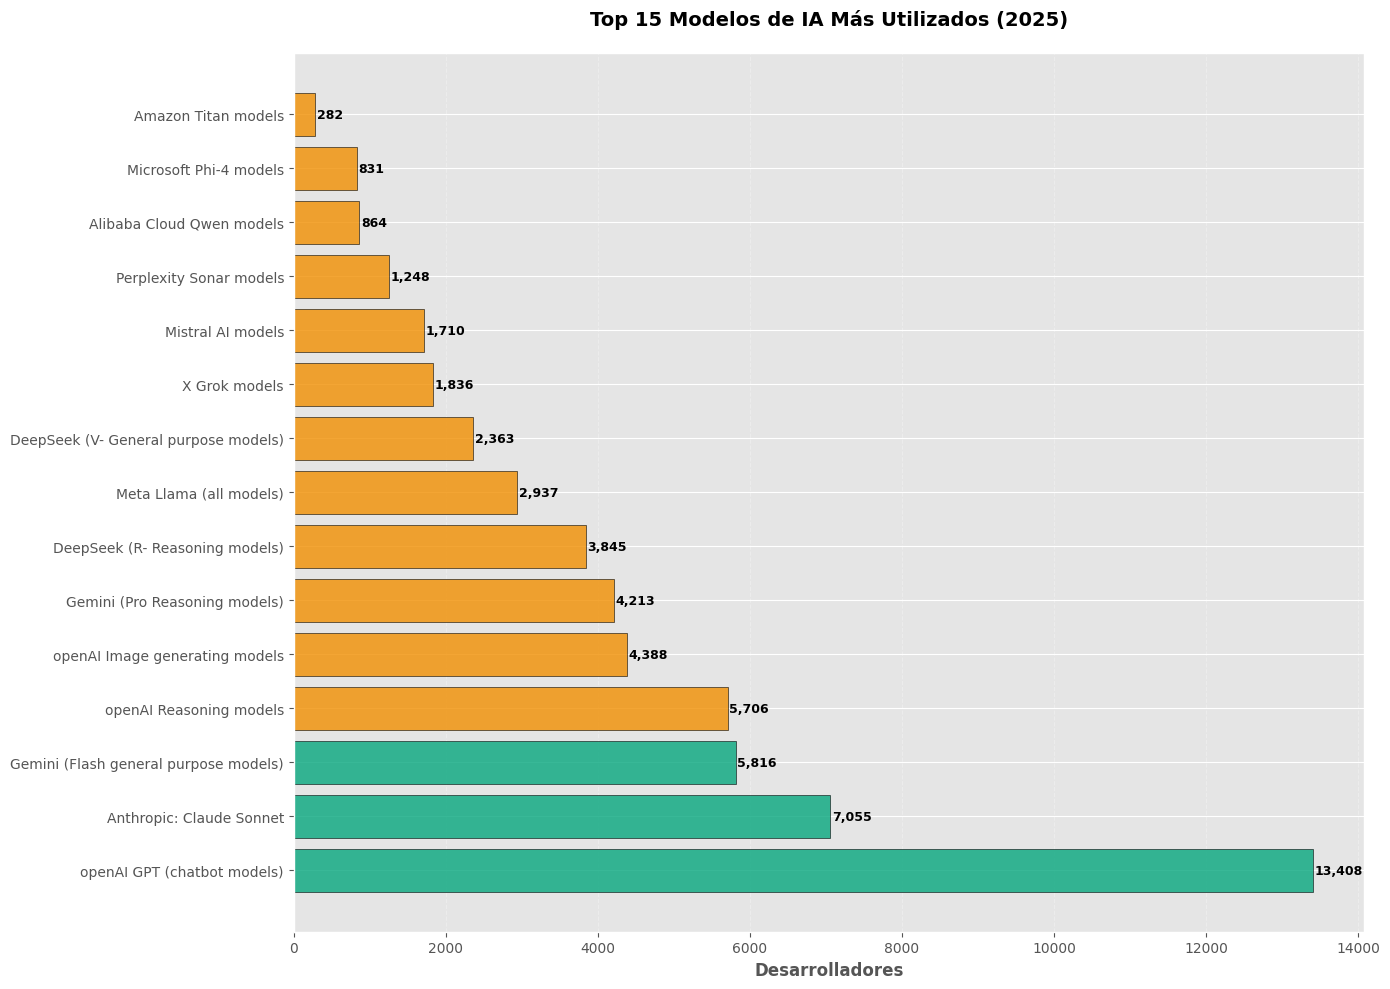


EXPLICACIÓN: Modelos de IA en 2025

Este gráfico muestra la diversidad del ecosistema de modelos de IA en 2025.
Los modelos destacados en verde son los 3 más populares (GPT, Claude, Gemini).

Hallazgos clave:
 OpenAI GPT domina el mercado (13,408 desarrolladores)
 Anthropic Claude Sonnet es el segundo más popular (7,055 desarrolladores)
 Hay una gran diversidad de modelos (17 modelos únicos mencionados)
 El ecosistema ha evolucionado de herramientas simples a modelos especializados
 Los desarrolladores están experimentando con múltiples modelos según el caso de uso

 Agentes de IA - Estado Actual (2025):


,Estado,Desarrolladores,Porcentaje (%)
1,"No, and I don't plan to",12075,24.58
2,"No, but I plan to",5553,11.30
3,"Yes, I use AI agents at work daily",4506,9.17
4,"No, I use AI exclusively in copilot/autocomple...",4394,8.94
5,"Yes, I use AI agents at work weekly",2864,5.83
6,"Yes, I use AI agents at work monthly or infreq...",2498,5.09


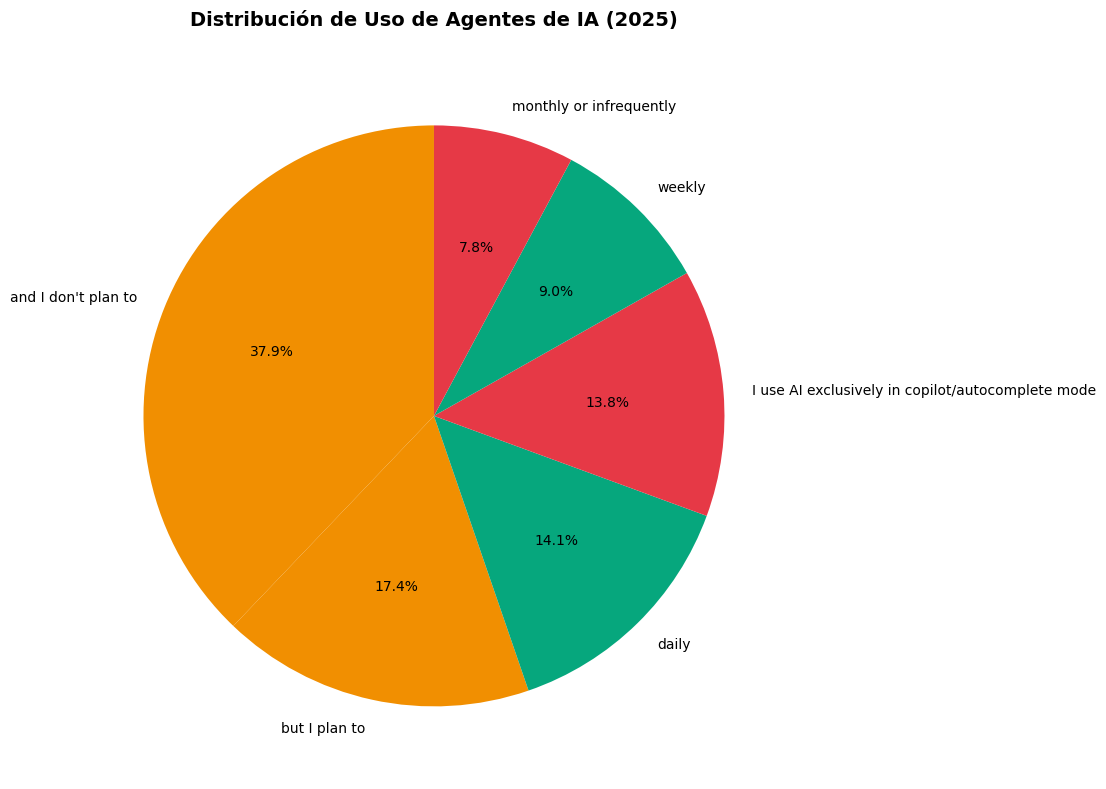


EXPLICACIÓN: Agentes de IA en 2025

Este gráfico muestra el estado actual de adopción de agentes de IA autónomos.
Los colores indican:
 Verde: Uso activo (diario/semanal)
 Naranja: Planificación de uso
 Rojo: Sin planes de uso

Hallazgos clave:
 15.0% de desarrolladores ya usan agentes IA activamente
 11.3% planean adoptarlos pronto
 Los agentes representan la evolución de herramientas a sistemas autónomos
 Esta es la próxima frontera en desarrollo asistido por IA


In [14]:
# Análisis de Modelos de IA en 2025
print("\n" + "=" * 80)
print("ANÁLISIS DE IA: MODELOS Y AGENTES (2025)")
print("=" * 80)

if "df_2025" in globals() and not df_2025.empty:
    print("\n STACK OVERFLOW 2025 - Modelos y Agentes de IA:")
    print("-" * 80)

    # Modelos de IA usados
    if "AIModelsHaveWorkedWith" in df_2025.columns:
        ai_models_2025 = (
            df_2025["AIModelsHaveWorkedWith"].dropna().str.split(";").explode()
        )
        models_counts_2025 = ai_models_2025.value_counts()

        print("\n Modelos de IA Utilizados (2025):")
        print(
            f" Total de desarrolladores que usan: {len(df_2025[df_2025['AIModelsHaveWorkedWith'].notna()]):,}"
        )
        print(f" Modelos únicos: {len(models_counts_2025)}")

        top_models_2025 = models_counts_2025.head(15)
        models_df_2025 = pd.DataFrame(
            {
                "Modelo": top_models_2025.index,
                "Desarrolladores": top_models_2025.values,
                "Porcentaje (%)": (top_models_2025.values / len(df_2025) * 100).round(
                    2
                ),
            }
        )
        models_df_2025.index = range(1, len(models_df_2025) + 1)
        print("\nTop 15 Modelos de IA (2025):")
        display(models_df_2025)

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 10))

        # Colores: verde para los top 3, naranja para el resto
        colors_models = [COLOR_SUCCESS] * 3 + [COLOR_ACCENT] * (
            len(top_models_2025) - 3
        )

        bars = ax.barh(
            range(len(top_models_2025)),
            top_models_2025.values,
            color=colors_models,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_yticks(range(len(top_models_2025)))
        ax.set_yticklabels(top_models_2025.index, fontsize=10)
        ax.set_xlabel("Desarrolladores", fontsize=12, fontweight="bold")
        ax.set_title(
            "Top 15 Modelos de IA Más Utilizados (2025)",
            fontsize=14,
            fontweight="bold",
            pad=20,
        )
        ax.grid(axis="x", alpha=0.3, linestyle="--")

        for i, (bar, count) in enumerate(
            zip(bars, top_models_2025.values, strict=True)
        ):
            ax.text(
                count + 20, i, f"{count:,}", va="center", fontsize=9, fontweight="bold"
            )

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "ai_models_2025.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Explicación
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Modelos de IA en 2025")
        print("=" * 80)
        print(
            "\nEste gráfico muestra la diversidad del ecosistema de modelos de IA en 2025."
        )
        print(
            "Los modelos destacados en verde son los 3 más populares (GPT, Claude, Gemini)."
        )
        print("\nHallazgos clave:")
        print(
            f" OpenAI GPT domina el mercado ({top_models_2025.iloc[0]:,} desarrolladores)"
        )
        print(
            f" Anthropic Claude Sonnet es el segundo más popular ({top_models_2025.iloc[1] if len(top_models_2025) > 1 else 0:,} desarrolladores)"
        )
        print(" Hay una gran diversidad de modelos (17 modelos únicos mencionados)")
        print(
            " El ecosistema ha evolucionado de herramientas simples a modelos especializados"
        )
        print(
            " Los desarrolladores están experimentando con múltiples modelos según el caso de uso"
        )
        print("=" * 80)

    # Agentes de IA
    if "AIAgents" in df_2025.columns:
        print("\n Agentes de IA - Estado Actual (2025):")
        agents_dist = df_2025["AIAgents"].value_counts()

        agents_df = pd.DataFrame(
            {
                "Estado": agents_dist.index,
                "Desarrolladores": agents_dist.values,
                "Porcentaje (%)": (agents_dist.values / len(df_2025) * 100).round(2),
            }
        )
        agents_df.index = range(1, len(agents_df) + 1)
        display(agents_df)

        # Visualización
        fig, ax = plt.subplots(figsize=(12, 8))

        # Preparar datos para el gráfico
        labels = []
        sizes = []
        colors_pie = []

        for i, (label, count) in enumerate(agents_dist.items()):
            labels.append(
                label.replace("Yes, I use AI agents at work ", "").replace("No, ", "")
            )
            sizes.append(count)
            if "daily" in label.lower() or "weekly" in label.lower():
                colors_pie.append(COLOR_SUCCESS)
            elif "plan to" in label.lower():
                colors_pie.append(COLOR_ACCENT)
            else:
                colors_pie.append("#E63946")  # Rojo para "no uso"

        wedges, texts, autotexts = ax.pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            colors=colors_pie,
            startangle=90,
            textprops={"fontsize": 10},
        )
        ax.set_title(
            "Distribución de Uso de Agentes de IA (2025)",
            fontsize=14,
            fontweight="bold",
            pad=20,
        )

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "ai_agents_2025.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Explicación
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Agentes de IA en 2025")
        print("=" * 80)
        print(
            "\nEste gráfico muestra el estado actual de adopción de agentes de IA autónomos."
        )
        print("Los colores indican:")
        print(" Verde: Uso activo (diario/semanal)")
        print(" Naranja: Planificación de uso")
        print(" Rojo: Sin planes de uso")
        print("\nHallazgos clave:")
        daily_users = agents_dist.get("Yes, I use AI agents at work daily", 0)
        weekly_users = agents_dist.get("Yes, I use AI agents at work weekly", 0)
        total_active = daily_users + weekly_users
        print(
            f" {total_active / len(df_2025) * 100:.1f}% de desarrolladores ya usan agentes IA activamente"
        )
        print(
            f" {agents_dist.get('No, but I plan to', 0) / len(df_2025) * 100:.1f}% planean adoptarlos pronto"
        )
        print(
            " Los agentes representan la evolución de herramientas a sistemas autónomos"
        )
        print(" Esta es la próxima frontera en desarrollo asistido por IA")
        print("=" * 80)
else:
    print(" Dataset SO 2025 no disponible para análisis de modelos y agentes")


ANÁLISIS DE IA: CASOS DE USO Y PERCEPCIONES

 Casos de Uso Principales de IA (2025):


,Caso de Uso,Menciones,Porcentaje (%)
1,Search for answers,6064,12.34
2,Generating content or synthetic data,4017,8.18
3,Learning new concepts or technologies,3710,7.55
4,Documenting code,3451,7.03
5,Creating or maintaining documentation,2781,5.66
6,Learning about a codebase,2336,4.76
7,Debugging or fixing code,2314,4.71
8,Testing code,2007,4.09
9,Writing code,1898,3.86
10,Predictive analytics,1230,2.50


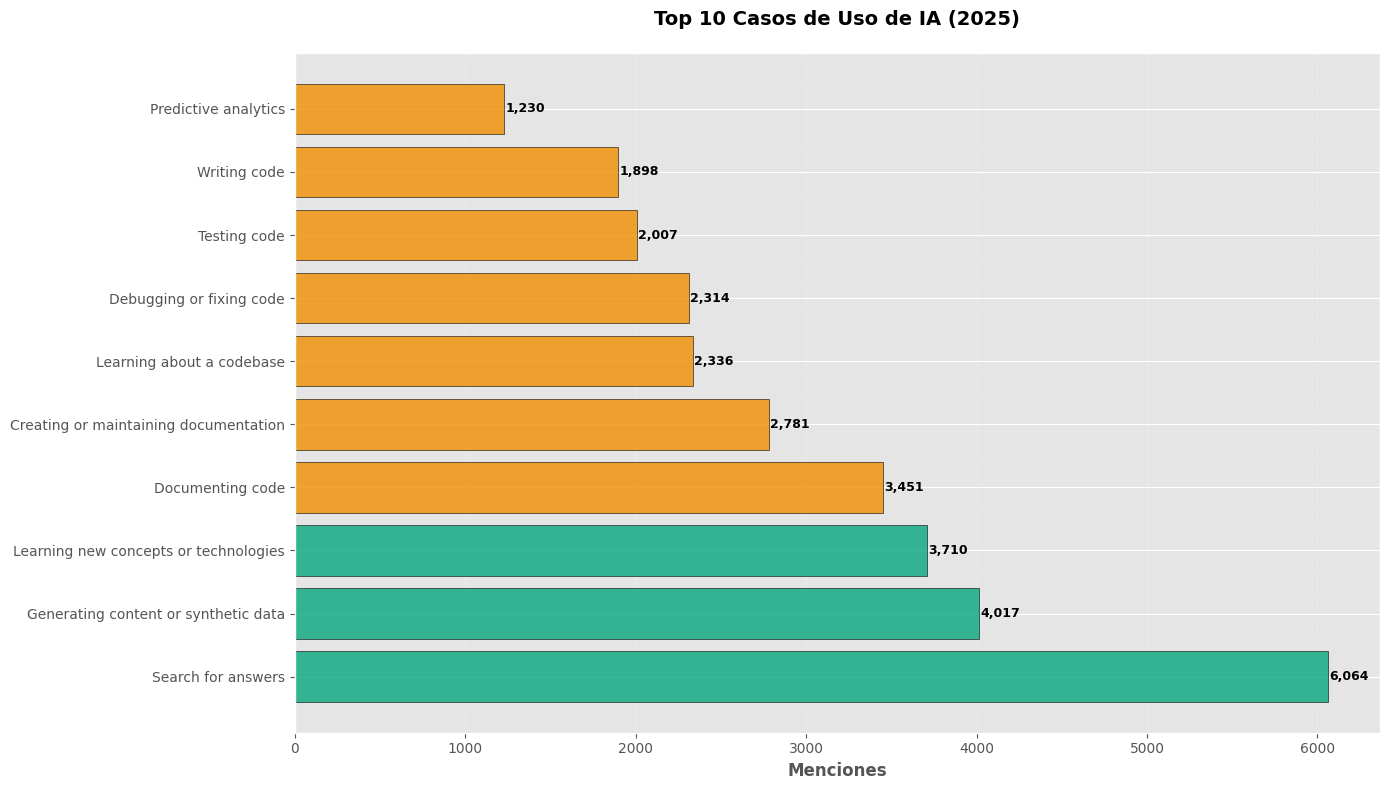


EXPLICACIÓN: Casos de Uso de IA

Este análisis muestra las tareas donde los desarrolladores usan IA principalmente.
Los casos de uso destacados en verde son los 3 más comunes.

Hallazgos clave:
 'Search for answers' es el caso de uso más común
 'Writing code' y 'Learning' son también muy populares
 La IA está transformando múltiples aspectos del workflow de desarrollo
 Los desarrolladores usan IA como asistente, no como reemplazo

 Sentimiento sobre IA (2025):


,Sentimiento,Desarrolladores,Porcentaje (%)
1,Favorable,12298,25.04
2,Very favorable,7668,15.61
3,Indifferent,5875,11.96
4,Unfavorable,3617,7.36
5,Very unfavorable,3217,6.55
6,Unsure,759,1.55


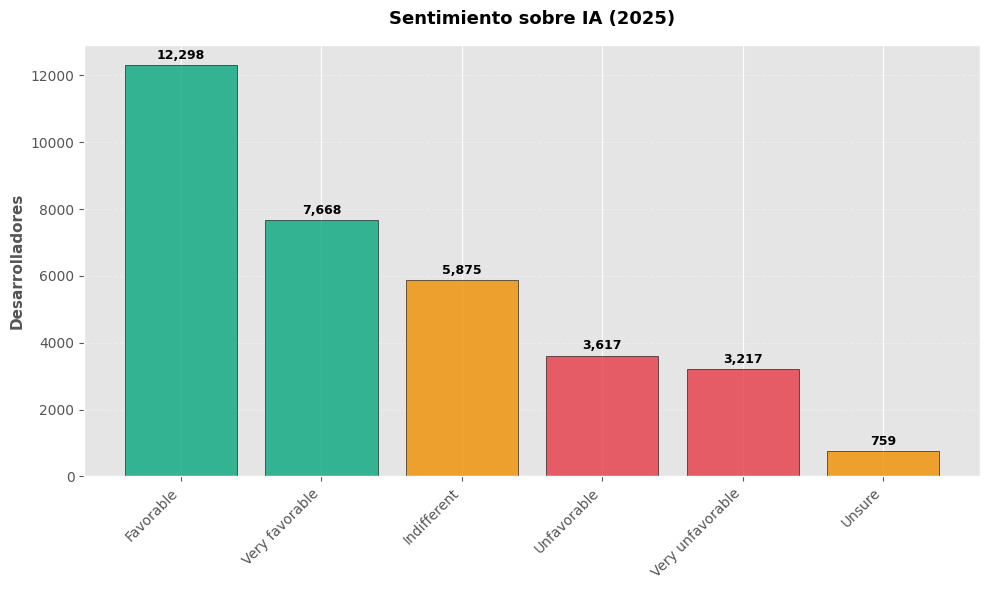


EXPLICACIÓN: Sentimiento sobre IA

Este gráfico muestra cómo los desarrolladores perciben la IA en general.
Los colores indican:
 Verde: Percepciones positivas (Favorable, Muy favorable)
 Naranja: Neutral (Indiferente)
 Rojo: Percepciones negativas (Desfavorable, Muy desfavorable)

Hallazgos clave:
 40.6% tiene una percepción favorable de la IA
 La mayoría de desarrolladores ve la IA como una herramienta positiva
 Hay optimismo sobre el futuro de la IA en desarrollo

 Frustraciones Principales con IA (2025):


,Frustración,Menciones,Porcentaje (%)
1,"AI solutions that are almost right, but not quite",20779,42.30
2,Debugging AI-generated code is more time-consu...,14239,28.99
3,I don’t use AI tools regularly,7412,15.09
4,I’ve become less confident in my own problem-s...,6311,12.85
5,It’s hard to understand how or why the code works,5137,10.46
6,Other (write in):,3655,7.44
7,I haven’t encountered any problems,1247,2.54


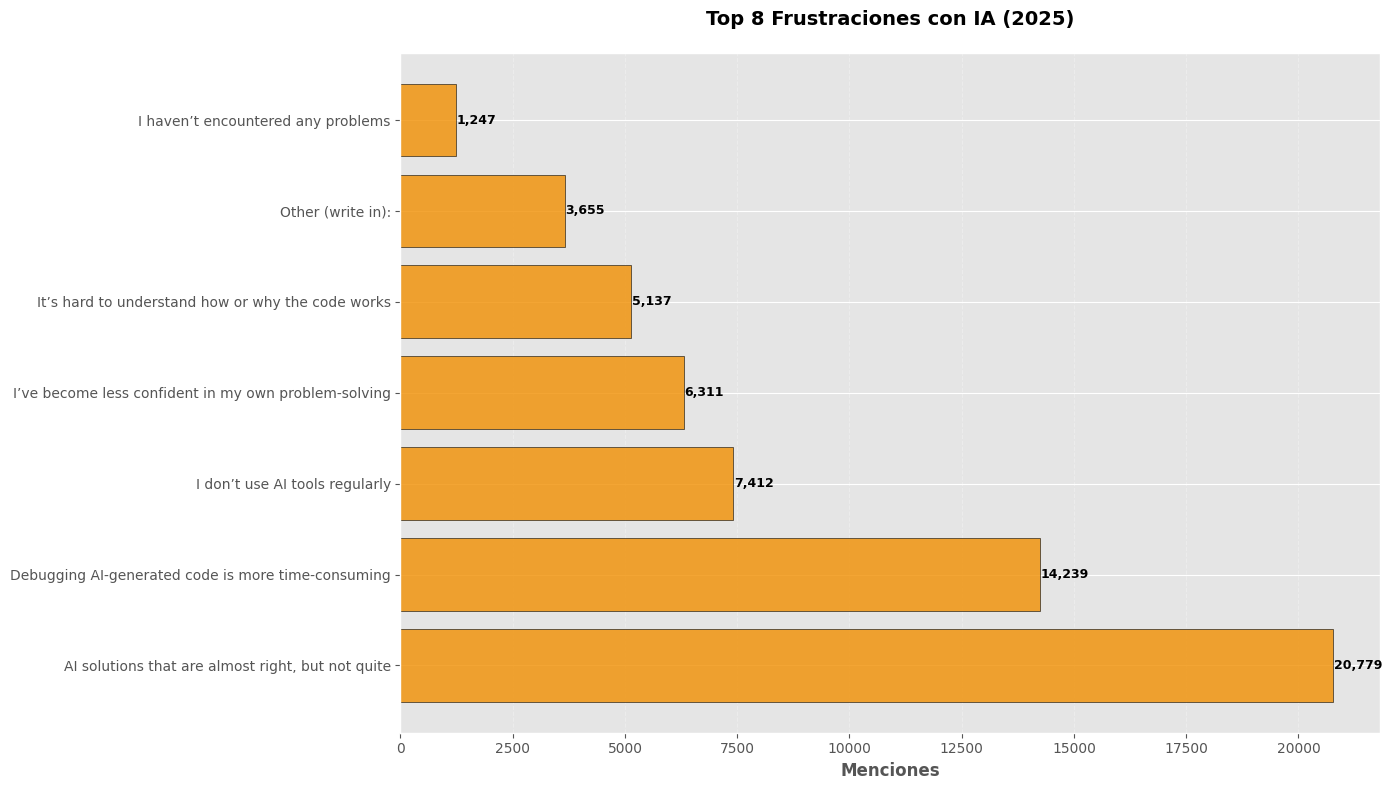


EXPLICACIÓN: Frustraciones con IA

Este análisis identifica los principales problemas que los desarrolladores enfrentan con IA.

Hallazgos clave:
 'AI solutions that are almost right, but not quite' es la frustración más común
 El debugging de código generado por IA puede ser más lento
 La IA aún requiere supervisión y validación humana
 Estas frustraciones reflejan la necesidad de mejorar la precisión y confiabilidad


In [15]:
# Análisis de Casos de Uso y Percepciones de IA
print("\n" + "=" * 80)
print("ANÁLISIS DE IA: CASOS DE USO Y PERCEPCIONES")
print("=" * 80)

if "df_2025" in globals() and not df_2025.empty:
    # Casos de uso principales
    if "AIToolCurrently mostly AI" in df_2025.columns:
        print("\n Casos de Uso Principales de IA (2025):")
        tool_uses = df_2025["AIToolCurrently mostly AI"].value_counts().head(10)

        # Procesar casos de uso (pueden venir separados por ';')
        all_uses = []
        for uses in df_2025["AIToolCurrently mostly AI"].dropna():
            if ";" in str(uses):
                all_uses.extend(str(uses).split(";"))
            else:
                all_uses.append(str(uses))

        use_counts = pd.Series(all_uses).value_counts().head(10)

        uses_df = pd.DataFrame(
            {
                "Caso de Uso": use_counts.index,
                "Menciones": use_counts.values,
                "Porcentaje (%)": (use_counts.values / len(df_2025) * 100).round(2),
            }
        )
        uses_df.index = range(1, len(uses_df) + 1)
        display(uses_df)

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 8))

        colors_uses = [
            COLOR_SUCCESS if i < 3 else COLOR_ACCENT for i in range(len(use_counts))
        ]
        bars = ax.barh(
            range(len(use_counts)),
            use_counts.values,
            color=colors_uses,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_yticks(range(len(use_counts)))
        ax.set_yticklabels(use_counts.index, fontsize=10)
        ax.set_xlabel("Menciones", fontsize=12, fontweight="bold")
        ax.set_title(
            "Top 10 Casos de Uso de IA (2025)", fontsize=14, fontweight="bold", pad=20
        )
        ax.grid(axis="x", alpha=0.3, linestyle="--")

        for i, (bar, count) in enumerate(zip(bars, use_counts.values, strict=True)):
            ax.text(
                count + 5, i, f"{count:,}", va="center", fontsize=9, fontweight="bold"
            )

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "ai_use_cases_2025.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Explicación
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Casos de Uso de IA")
        print("=" * 80)
        print(
            "\nEste análisis muestra las tareas donde los desarrolladores usan IA principalmente."
        )
        print("Los casos de uso destacados en verde son los 3 más comunes.")
        print("\nHallazgos clave:")
        print(" 'Search for answers' es el caso de uso más común")
        print(" 'Writing code' y 'Learning' son también muy populares")
        print(" La IA está transformando múltiples aspectos del workflow de desarrollo")
        print(" Los desarrolladores usan IA como asistente, no como reemplazo")
        print("=" * 80)

    # Percepciones sobre IA
    if "AISent" in df_2025.columns:
        print("\n Sentimiento sobre IA (2025):")
        sentiment_dist = df_2025["AISent"].value_counts()

        sentiment_df = pd.DataFrame(
            {
                "Sentimiento": sentiment_dist.index,
                "Desarrolladores": sentiment_dist.values,
                "Porcentaje (%)": (sentiment_dist.values / len(df_2025) * 100).round(2),
            }
        )
        sentiment_df.index = range(1, len(sentiment_df) + 1)
        display(sentiment_df)

        # Visualización
        fig, ax = plt.subplots(figsize=(10, 6))

        # Mapear sentimientos a colores
        color_map = {
            "Very favorable": COLOR_SUCCESS,
            "Favorable": COLOR_SUCCESS,
            "Indifferent": COLOR_ACCENT,
            "Unfavorable": "#E63946",
            "Very unfavorable": "#E63946",
        }
        colors_sent = [
            color_map.get(sent, COLOR_ACCENT) for sent in sentiment_dist.index
        ]

        bars = ax.bar(
            range(len(sentiment_dist)),
            sentiment_dist.values,
            color=colors_sent,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_xticks(range(len(sentiment_dist)))
        ax.set_xticklabels(sentiment_dist.index, rotation=45, ha="right", fontsize=10)
        ax.set_ylabel("Desarrolladores", fontsize=11, fontweight="bold")
        ax.set_title(
            "Sentimiento sobre IA (2025)", fontsize=13, fontweight="bold", pad=15
        )
        ax.grid(axis="y", alpha=0.3, linestyle="--")

        for bar, count in zip(bars, sentiment_dist.values, strict=True):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                count + 100,
                f"{count:,}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "ai_sentiment_2025.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Explicación
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Sentimiento sobre IA")
        print("=" * 80)
        print(
            "\nEste gráfico muestra cómo los desarrolladores perciben la IA en general."
        )
        print("Los colores indican:")
        print(" Verde: Percepciones positivas (Favorable, Muy favorable)")
        print(" Naranja: Neutral (Indiferente)")
        print(" Rojo: Percepciones negativas (Desfavorable, Muy desfavorable)")
        print("\nHallazgos clave:")
        favorable = sentiment_dist.get("Favorable", 0) + sentiment_dist.get(
            "Very favorable", 0
        )
        print(
            f" {favorable / len(df_2025) * 100:.1f}% tiene una percepción favorable de la IA"
        )
        print(" La mayoría de desarrolladores ve la IA como una herramienta positiva")
        print(" Hay optimismo sobre el futuro de la IA en desarrollo")
        print("=" * 80)

    # Frustraciones con IA
    if "AIFrustration" in df_2025.columns:
        print("\n Frustraciones Principales con IA (2025):")
        frustration_text = df_2025["AIFrustration"].dropna().astype(str)

        # Procesar frustraciones (pueden venir separadas por ';')
        all_frustrations = []
        for frus in frustration_text:
            if ";" in frus:
                all_frustrations.extend(frus.split(";"))
            else:
                all_frustrations.append(frus)

        frustration_counts = pd.Series(all_frustrations).value_counts().head(8)

        frust_df = pd.DataFrame(
            {
                "Frustración": frustration_counts.index,
                "Menciones": frustration_counts.values,
                "Porcentaje (%)": (
                    frustration_counts.values / len(df_2025) * 100
                ).round(2),
            }
        )
        frust_df.index = range(1, len(frust_df) + 1)
        display(frust_df)

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 8))

        colors_frust = [COLOR_ACCENT] * len(frustration_counts)
        bars = ax.barh(
            range(len(frustration_counts)),
            frustration_counts.values,
            color=colors_frust,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_yticks(range(len(frustration_counts)))
        ax.set_yticklabels(frustration_counts.index, fontsize=10)
        ax.set_xlabel("Menciones", fontsize=12, fontweight="bold")
        ax.set_title(
            "Top 8 Frustraciones con IA (2025)", fontsize=14, fontweight="bold", pad=20
        )
        ax.grid(axis="x", alpha=0.3, linestyle="--")

        for i, (bar, count) in enumerate(
            zip(bars, frustration_counts.values, strict=True)
        ):
            ax.text(
                count + 10, i, f"{count:,}", va="center", fontsize=9, fontweight="bold"
            )

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "ai_frustrations_2025.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Explicación
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Frustraciones con IA")
        print("=" * 80)
        print(
            "\nEste análisis identifica los principales problemas que los desarrolladores enfrentan con IA."
        )
        print("\nHallazgos clave:")
        print(
            " 'AI solutions that are almost right, but not quite' es la frustración más común"
        )
        print(" El debugging de código generado por IA puede ser más lento")
        print(" La IA aún requiere supervisión y validación humana")
        print(
            " Estas frustraciones reflejan la necesidad de mejorar la precisión y confiabilidad"
        )
        print("=" * 80)
else:
    print(" Dataset SO 2025 no disponible para análisis de casos de uso y percepciones")


ANÁLISIS TEMPORAL: EVOLUCIÓN DE IA 2023 → 2025

 Comparando adopción de IA entre 2023 y 2025:
--------------------------------------------------------------------------------

Comparación de Adopción de IA: 2023 vs 2025
 NOTA: La estructura de preguntas cambió entre años (ver explicación abajo)


,Herramienta,2023 (desarrolladores),2023 (%),2025 (desarrolladores),2025 (%),Crecimiento (pp)
1,ChatGPT,52462,58.82,6885,14.02,-44.81
2,GitHub Copilot,22078,24.76,5733,11.67,-13.08



 Contexto: Adopción General vs Específica (2025)


,Métrica,Porcentaje (%),Explicación
1,Adopción general de IA (2025),68.57,Desarrolladores que usan cualquier herramienta...
2,ChatGPT específico (2025),14.02,Desarrolladores que mencionan ChatGPT específi...
3,GitHub Copilot específico (2025),11.67,Desarrolladores que mencionan GitHub Copilot e...


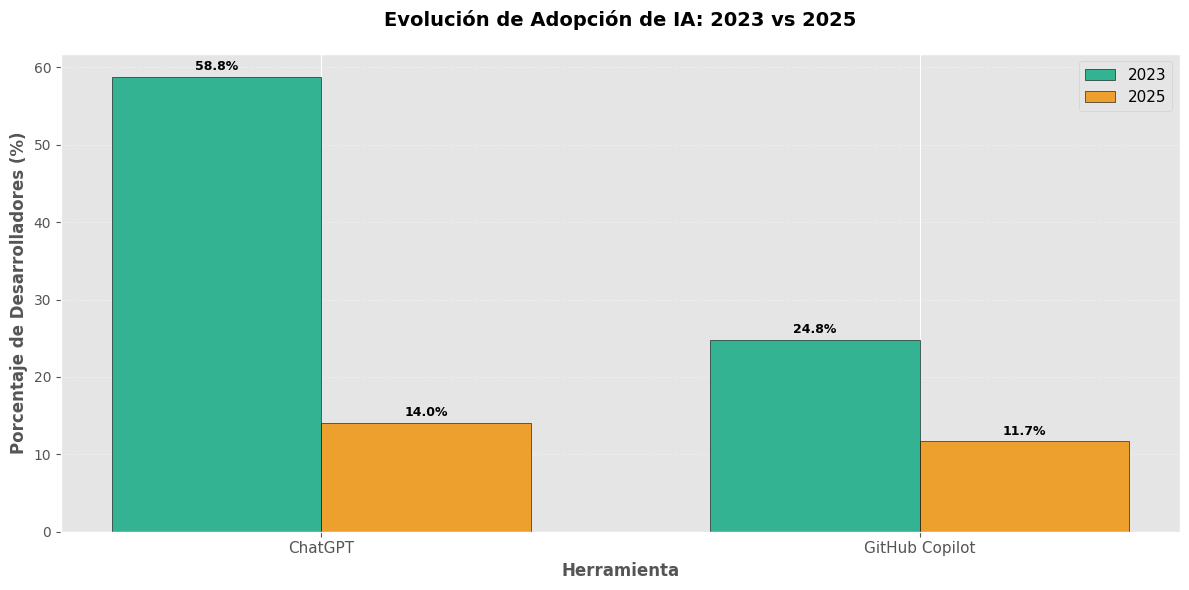


EXPLICACIÓN: Evolución Temporal de IA

Este análisis compara la adopción de herramientas de IA entre 2023 y 2025.
El gráfico muestra barras donde:
 Verde: Porcentaje de adopción en 2023
 Naranja: Porcentaje de adopción en 2025

 NOTA IMPORTANTE SOBRE LA COMPARACIÓN:
 SO 2023: Preguntas específicas sobre herramientas de búsqueda y desarrollo
 - AISearchHaveWorkedWith: Herramientas de búsqueda con IA
 - AIDevHaveWorkedWith: Herramientas de desarrollo con IA
 SO 2025: Estructura diferente, preguntas más específicas sobre agentes y modelos
 - AIAgentExternal: Agentes externos de IA (más específico)
 - Búsqueda realizada en múltiples columnas para capturar todos los casos
 La diferencia en estructura puede afectar la comparación directa

Hallazgos clave:
 ChatGPT: Diferencia de -44.8 puntos porcentuales
 (Nota: La estructura de preguntas cambió, puede no reflejar disminución real)
 GitHub Copilot: Diferencia de -13.1 puntos porcentuales
 (Nota: La estructura de preguntas cambió, puede no r

,Herramienta,Desarrolladores,Porcentaje (%)
1,ChatGPT web / desktop / mobile apps (not insid...,10255,41.80
2,GitHub Copilot,7605,31.00
3,JetBrains AI Assistant,4036,16.45
4,Cursor,2469,10.06
5,Anthropic Claude web / desktop / mobile apps (...,2199,8.96
6,Google Gemini web / mobile apps (not inside th...,2100,8.56
7,JetBrains Junie,1578,6.43
8,DeepSeek apps or self-hosted / locally install...,1472,6.00
9,Anthropic Claude Code,1029,4.19
10,Perplexity,766,3.12


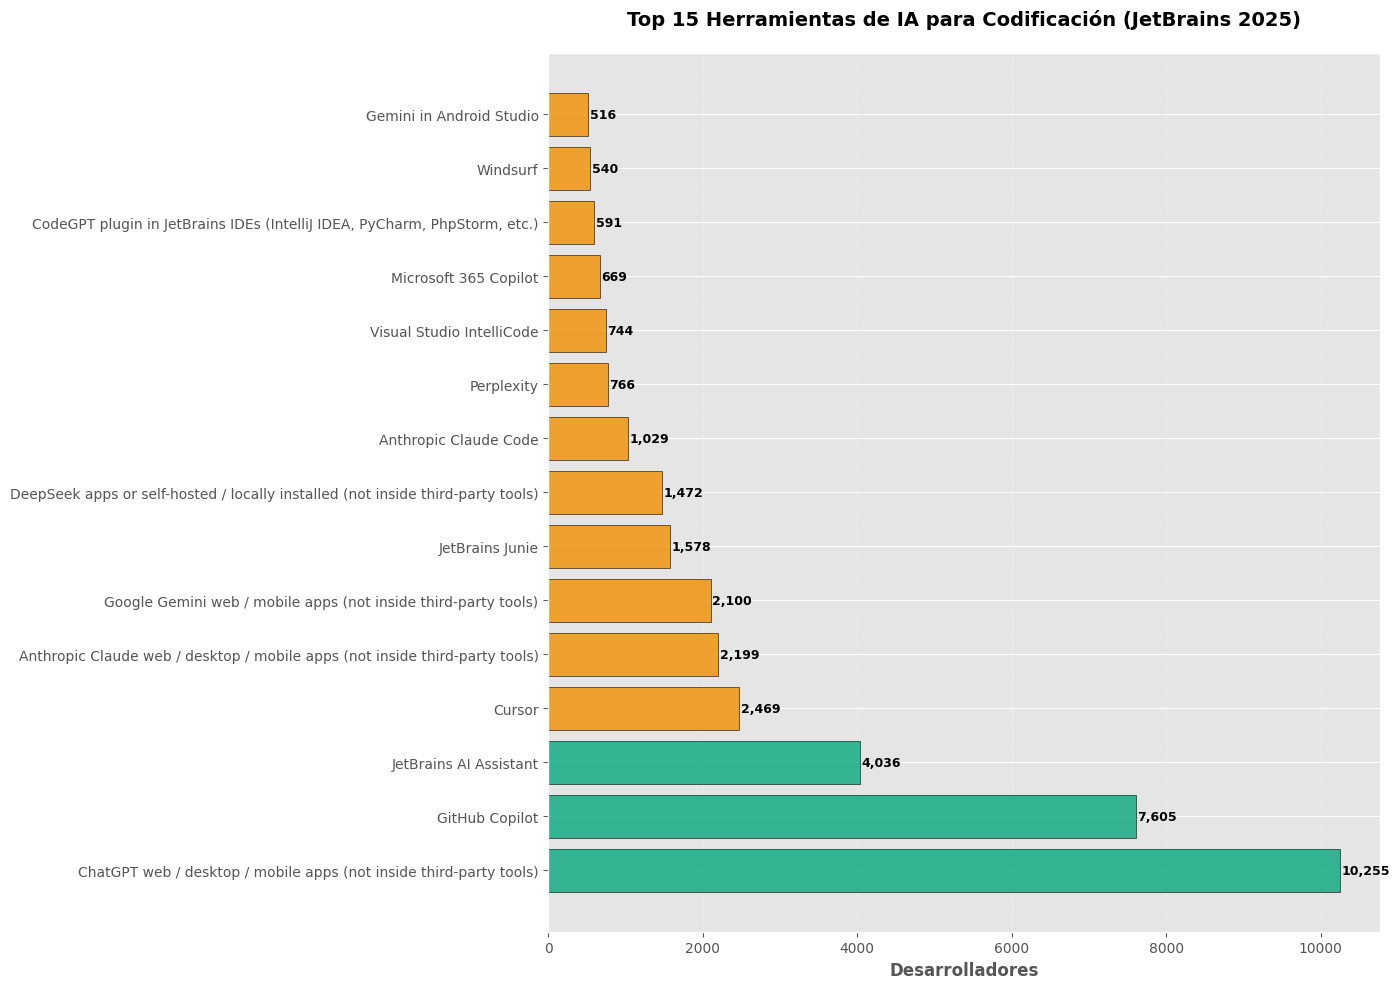


 COMPARACIÓN: JetBrains vs Stack Overflow 2025
--------------------------------------------------------------------------------

Comparación de Adopción: JetBrains vs Stack Overflow 2025


,Herramienta,JetBrains 2025,JetBrains (%),Stack Overflow 2025,SO 2025 (%)
1,GitHub Copilot,7605,31.0,5653,11.51
2,ChatGPT,10255,41.8,6801,13.84



EXPLICACIÓN: Herramientas de IA en JetBrains 2025

Este análisis muestra las herramientas de IA más utilizadas para codificación según JetBrains 2025.
Los datos de JetBrains complementan los de Stack Overflow con un enfoque más específico en IDEs y herramientas de desarrollo.

Hallazgos clave:
 Herramienta más popular: ChatGPT web / desktop / mobile apps (not inside third-party tools) (10,255 desarrolladores, 41.8%)
 JetBrains AI Assistant: 4,036 desarrolladores
 El dataset de JetBrains tiene 46 herramientas de IA únicas documentadas
 Los desarrolladores están experimentando con múltiples herramientas según sus necesidades
 La integración con IDEs es un factor clave en la adopción


In [16]:
# Comparación Temporal: Evolución de IA 2023 vs 2025
print("\n" + "=" * 80)
print("ANÁLISIS TEMPORAL: EVOLUCIÓN DE IA 2023 → 2025")
print("=" * 80)

# Usar df_2023 y df_2025 directamente (no el dataset combinado)
if (
    "df_2023" in globals()
    and "df_2025" in globals()
    and not df_2023.empty
    and not df_2025.empty
):
    print("\n Comparando adopción de IA entre 2023 y 2025:")
    print("-" * 80)

    # NOTA IMPORTANTE: La estructura de preguntas cambió entre 2023 y 2025
    # 2023: Preguntas específicas sobre herramientas de búsqueda y desarrollo
    # 2025: Estructura diferente, AIAgentExternal es más específica (solo agentes externos)

    # Comparar adopción de ChatGPT
    chatgpt_2023 = 0
    chatgpt_2025 = 0

    # SO 2023: usar AISearchHaveWorkedWith (herramientas de búsqueda con IA)
    if "AISearchHaveWorkedWith" in df_2023.columns:
        df_2023_ai = df_2023["AISearchHaveWorkedWith"].dropna()
        chatgpt_2023 = (
            df_2023_ai.astype(str).str.contains("ChatGPT", case=False, na=False).sum()
        )

    # SO 2025: buscar en TODAS las columnas de IA (estructura diferente)
    # AIAgentExternal es la principal, pero también buscar en otras
    if "AIAgentExternal" in df_2025.columns:
        # Buscar en AIAgentExternal (principal)
        chatgpt_2025_set = set(
            df_2025[
                df_2025["AIAgentExternal"]
                .astype(str)
                .str.contains("ChatGPT", case=False, na=False)
            ].index
        )

        # Buscar en otras columnas de IA para capturar todos los casos
        ai_cols_2025 = [
            col
            for col in df_2025.columns
            if "AI" in col.upper() and df_2025[col].dtype == "object"
        ]
        for col in ai_cols_2025:
            if col != "AIAgentExternal":
                mask = (
                    df_2025[col]
                    .astype(str)
                    .str.contains("ChatGPT", case=False, na=False)
                )
                chatgpt_2025_set.update(df_2025[mask].index)

        chatgpt_2025 = len(chatgpt_2025_set)

    total_2023 = len(df_2023)
    total_2025 = len(df_2025)

    pct_2023 = (chatgpt_2023 / total_2023 * 100) if total_2023 > 0 else 0
    pct_2025 = (chatgpt_2025 / total_2025 * 100) if total_2025 > 0 else 0

    # Comparar GitHub Copilot
    copilot_2023 = 0
    copilot_2025 = 0

    # SO 2023: usar AIDevHaveWorkedWith (herramientas de desarrollo con IA)
    if "AIDevHaveWorkedWith" in df_2023.columns:
        df_2023_dev = df_2023["AIDevHaveWorkedWith"].dropna()
        copilot_2023 = (
            df_2023_dev.astype(str)
            .str.contains("GitHub Copilot", case=False, na=False)
            .sum()
        )

    # SO 2025: buscar en TODAS las columnas de IA (estructura diferente)
    if "AIAgentExternal" in df_2025.columns:
        # Buscar en AIAgentExternal (principal)
        copilot_2025_set = set(
            df_2025[
                df_2025["AIAgentExternal"]
                .astype(str)
                .str.contains("GitHub Copilot", case=False, na=False)
            ].index
        )

        # Buscar en otras columnas de IA para capturar todos los casos
        ai_cols_2025 = [
            col
            for col in df_2025.columns
            if "AI" in col.upper() and df_2025[col].dtype == "object"
        ]
        for col in ai_cols_2025:
            if col != "AIAgentExternal":
                mask = (
                    df_2025[col]
                    .astype(str)
                    .str.contains("GitHub Copilot", case=False, na=False)
                )
                copilot_2025_set.update(df_2025[mask].index)

        copilot_2025 = len(copilot_2025_set)

    # Crear DataFrame comparativo
    pct_copilot_2023 = (copilot_2023 / total_2023 * 100) if total_2023 > 0 else 0
    pct_copilot_2025 = (copilot_2025 / total_2025 * 100) if total_2025 > 0 else 0

    comparison_ai = pd.DataFrame(
        {
            "Herramienta": ["ChatGPT", "GitHub Copilot"],
            "2023 (desarrolladores)": [chatgpt_2023, copilot_2023],
            "2023 (%)": [round(pct_2023, 2), round(pct_copilot_2023, 2)],
            "2025 (desarrolladores)": [chatgpt_2025, copilot_2025],
            "2025 (%)": [round(pct_2025, 2), round(pct_copilot_2025, 2)],
            "Crecimiento (pp)": [
                round((pct_2025 - pct_2023), 2),
                round((pct_copilot_2025 - pct_copilot_2023), 2),
            ],
        }
    )
    comparison_ai.index = range(1, len(comparison_ai) + 1)
    print("\nComparación de Adopción de IA: 2023 vs 2025")
    print(" NOTA: La estructura de preguntas cambió entre años (ver explicación abajo)")
    display(comparison_ai)

    # Mostrar contexto adicional: adopción general de IA en 2025
    if "AISelect" in df_2025.columns:
        ai_select_yes = df_2025[df_2025["AISelect"].notna()].shape[0]
        ai_select_pct = ai_select_yes / len(df_2025) * 100

        context_df = pd.DataFrame(
            {
                "Métrica": [
                    "Adopción general de IA (2025)",
                    "ChatGPT específico (2025)",
                    "GitHub Copilot específico (2025)",
                ],
                "Porcentaje (%)": [
                    round(ai_select_pct, 2),
                    round(pct_2025, 2),
                    round(pct_copilot_2025, 2),
                ],
                "Explicación": [
                    "Desarrolladores que usan cualquier herramienta de IA",
                    "Desarrolladores que mencionan ChatGPT específicamente",
                    "Desarrolladores que mencionan GitHub Copilot específicamente",
                ],
            }
        )
        context_df.index = range(1, len(context_df) + 1)
        print("\n Contexto: Adopción General vs Específica (2025)")
        display(context_df)

    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(comparison_ai))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        comparison_ai["2023 (%)"],
        width,
        label="2023",
        color=COLOR_SUCCESS,
        alpha=0.8,
        edgecolor="black",
    )
    bars2 = ax.bar(
        x + width / 2,
        comparison_ai["2025 (%)"],
        width,
        label="2025",
        color=COLOR_ACCENT,
        alpha=0.8,
        edgecolor="black",
    )

    ax.set_xlabel("Herramienta", fontsize=12, fontweight="bold")
    ax.set_ylabel("Porcentaje de Desarrolladores (%)", fontsize=12, fontweight="bold")
    ax.set_title(
        "Evolución de Adopción de IA: 2023 vs 2025",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_ai["Herramienta"], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.5,
                f"{height:.1f}%",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )
    plt.tight_layout()
    plt.savefig(
        project_root / "data" / "08_reporting" / "ai_evolution_2023_2025.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Explicación
    print("\n" + "=" * 80)
    print("EXPLICACIÓN: Evolución Temporal de IA")
    print("=" * 80)
    print(
        "\nEste análisis compara la adopción de herramientas de IA entre 2023 y 2025."
    )
    print("El gráfico muestra barras donde:")
    print(" Verde: Porcentaje de adopción en 2023")
    print(" Naranja: Porcentaje de adopción en 2025")
    print("\n NOTA IMPORTANTE SOBRE LA COMPARACIÓN:")
    print(" SO 2023: Preguntas específicas sobre herramientas de búsqueda y desarrollo")
    print(" - AISearchHaveWorkedWith: Herramientas de búsqueda con IA")
    print(" - AIDevHaveWorkedWith: Herramientas de desarrollo con IA")
    print(
        " SO 2025: Estructura diferente, preguntas más específicas sobre agentes y modelos"
    )
    print(" - AIAgentExternal: Agentes externos de IA (más específico)")
    print(" - Búsqueda realizada en múltiples columnas para capturar todos los casos")
    print(" La diferencia en estructura puede afectar la comparación directa")
    print("\nHallazgos clave:")
    growth_chatgpt = (
        comparison_ai.loc[1, "Crecimiento (pp)"] if len(comparison_ai) > 0 else 0
    )
    growth_copilot = (
        comparison_ai.loc[2, "Crecimiento (pp)"] if len(comparison_ai) > 1 else 0
    )

    # Interpretar el cambio
    if growth_chatgpt < 0:
        print(f" ChatGPT: Diferencia de {growth_chatgpt:.1f} puntos porcentuales")
        print(
            " (Nota: La estructura de preguntas cambió, puede no reflejar disminución real)"
        )
    else:
        print(f" ChatGPT: Crecimiento de {growth_chatgpt:.1f} puntos porcentuales")

    if growth_copilot < 0:
        print(
            f" GitHub Copilot: Diferencia de {growth_copilot:.1f} puntos porcentuales"
        )
        print(
            " (Nota: La estructura de preguntas cambió, puede no reflejar disminución real)"
        )
    else:
        print(
            f" GitHub Copilot: Crecimiento de {growth_copilot:.1f} puntos porcentuales"
        )

    # Mostrar adopción general de IA en 2025 si está disponible
    if "AISelect" in df_2025.columns:
        ai_select_yes = df_2025[df_2025["AISelect"].notna()].shape[0]
        ai_select_pct = ai_select_yes / len(df_2025) * 100
        print(
            f"\n Adopción general de IA en 2025 (AISelect): {ai_select_pct:.1f}% de desarrolladores"
        )
        print(" Esto indica que la adopción de IA sigue siendo muy alta")

    print(" La IA sigue siendo una tecnología en crecimiento y transformación")
    print("=" * 80)
else:
    print(" Se requieren datos de ambos años (2023 y 2025) para análisis temporal")

# Análisis complementario: JetBrains 2025 - Herramientas de IA para Codificación
print("\n" + "=" * 80)
print("ANÁLISIS COMPLEMENTARIO: JETBRAINS 2025 - HERRAMIENTAS DE IA PARA CODIFICACIÓN")
print("=" * 80)

if "df_jb_2025" in globals() and not df_jb_2025.empty:
    print("\n JETBRAINS DEVELOPER ECOSYSTEM 2025 - Herramientas de IA:")
    print("-" * 80)

    # Buscar columnas de uso de IA para codificación
    ai_coding_cols = [
        col for col in df_jb_2025.columns if col.startswith("usage_ai_coding::")
    ]

    if ai_coding_cols:
        print("\n Herramientas de IA para Codificación (JetBrains 2025):")
        print(f" Total de herramientas disponibles: {len(ai_coding_cols)}")

        # Contar uso de cada herramienta
        tool_usage = {}
        for col in ai_coding_cols:
            tool_name = col.replace("usage_ai_coding::", "")
            count = df_jb_2025[col].notna().sum()
            if count > 0:
                tool_usage[tool_name] = count

        # Ordenar por uso
        tool_usage_sorted = dict(
            sorted(tool_usage.items(), key=lambda x: x[1], reverse=True)
        )

        # Top 15 herramientas
        top_15_jb = dict(list(tool_usage_sorted.items())[:15])

        jb_tools_df = pd.DataFrame(
            {
                "Herramienta": list(top_15_jb.keys()),
                "Desarrolladores": list(top_15_jb.values()),
                "Porcentaje (%)": [
                    round(v / len(df_jb_2025) * 100, 2) for v in top_15_jb.values()
                ],
            }
        )
        jb_tools_df.index = range(1, len(jb_tools_df) + 1)
        print("\nTop 15 Herramientas de IA para Codificación (JetBrains 2025):")
        display(jb_tools_df)

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 10))

        # Colores: verde para las top 3, naranja para el resto
        colors_jb = [COLOR_SUCCESS] * 3 + [COLOR_ACCENT] * (len(top_15_jb) - 3)

        bars = ax.barh(
            range(len(top_15_jb)),
            list(top_15_jb.values()),
            color=colors_jb,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_yticks(range(len(top_15_jb)))
        ax.set_yticklabels(list(top_15_jb.keys()), fontsize=10)
        ax.set_xlabel("Desarrolladores", fontsize=12, fontweight="bold")
        ax.set_title(
            "Top 15 Herramientas de IA para Codificación (JetBrains 2025)",
            fontsize=14,
            fontweight="bold",
            pad=20,
        )
        ax.grid(axis="x", alpha=0.3, linestyle="--")

        for i, (bar, count) in enumerate(zip(bars, top_15_jb.values(), strict=True)):
            ax.text(
                count + 20, i, f"{count:,}", va="center", fontsize=9, fontweight="bold"
            )

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "ai_tools_jetbrains_2025.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        # Comparación con Stack Overflow (si está disponible)
        if "df_2025" in globals() and not df_2025.empty:
            print("\n COMPARACIÓN: JetBrains vs Stack Overflow 2025")
            print("-" * 80)

            # GitHub Copilot en ambos
            copilot_jb = tool_usage_sorted.get("GitHub Copilot", 0)
            copilot_so = 0
            # SO 2025: usar AIAgentExternal (estructura diferente a 2023)
            if "AIAgentExternal" in df_2025.columns:
                copilot_so = (
                    df_2025["AIAgentExternal"]
                    .astype(str)
                    .str.contains("GitHub Copilot", case=False, na=False)
                    .sum()
                )

            # ChatGPT en ambos (si está disponible en SO)
            chatgpt_jb = tool_usage_sorted.get(
                "ChatGPT web / desktop / mobile apps (not inside third-party tools)", 0
            )
            chatgpt_so = 0
            # SO 2025: usar AIAgentExternal (estructura diferente a 2023)
            if "AIAgentExternal" in df_2025.columns:
                chatgpt_so = (
                    df_2025["AIAgentExternal"]
                    .astype(str)
                    .str.contains("ChatGPT", case=False, na=False)
                    .sum()
                )

            comparison_jb_so = pd.DataFrame(
                {
                    "Herramienta": ["GitHub Copilot", "ChatGPT"],
                    "JetBrains 2025": [copilot_jb, chatgpt_jb],
                    "JetBrains (%)": [
                        round(copilot_jb / len(df_jb_2025) * 100, 2),
                        round(chatgpt_jb / len(df_jb_2025) * 100, 2),
                    ],
                    "Stack Overflow 2025": [copilot_so, chatgpt_so],
                    "SO 2025 (%)": [
                        round(copilot_so / len(df_2025) * 100, 2)
                        if len(df_2025) > 0
                        else 0,
                        round(chatgpt_so / len(df_2025) * 100, 2)
                        if len(df_2025) > 0
                        else 0,
                    ],
                }
            )
            comparison_jb_so.index = range(1, len(comparison_jb_so) + 1)
            print("\nComparación de Adopción: JetBrains vs Stack Overflow 2025")
            display(comparison_jb_so)

        # Explicación
        print("\n" + "=" * 80)
        print("EXPLICACIÓN: Herramientas de IA en JetBrains 2025")
        print("=" * 80)
        print(
            "\nEste análisis muestra las herramientas de IA más utilizadas para codificación según JetBrains 2025."
        )
        print(
            "Los datos de JetBrains complementan los de Stack Overflow con un enfoque más específico en IDEs y herramientas de desarrollo."
        )
        print("\nHallazgos clave:")
        top_tool = list(top_15_jb.keys())[0]
        top_count = list(top_15_jb.values())[0]
        print(
            f" Herramienta más popular: {top_tool} ({top_count:,} desarrolladores, {top_count / len(df_jb_2025) * 100:.1f}%)"
        )
        print(
            f" JetBrains AI Assistant: {tool_usage_sorted.get('JetBrains AI Assistant', 0):,} desarrolladores"
        )
        print(
            f" El dataset de JetBrains tiene {len(ai_coding_cols)} herramientas de IA únicas documentadas"
        )
        print(
            " Los desarrolladores están experimentando con múltiples herramientas según sus necesidades"
        )
        print(" La integración con IDEs es un factor clave en la adopción")
        print("=" * 80)
    else:
        print(
            " No se encontraron columnas de uso de IA para codificación en JetBrains 2025"
        )
else:
    print(" Dataset JetBrains 2025 no disponible para análisis de IA")

## 6. Análisis Temporal: Comparación 2023 vs 2025

Este análisis compara las tendencias tecnológicas entre las encuestas de Stack Overflow 2023 y 2025, permitiendo identificar:

- **Tecnologías en crecimiento**: Lenguajes y herramientas que han ganado popularidad
- **Tecnologías en declive**: Tecnologías que están perdiendo adopción
- **Tendencias de salarios**: Cambios en la remuneración por tecnología
- **Evolución del ecosistema**: Cambios en las preferencias de los desarrolladores

**Nota**: Este análisis utiliza los datasets combinados de Stack Overflow 2023 y 2025 que ya están disponibles.

ANÁLISIS TEMPORAL: Comparación Stack Overflow 2023 vs 2025

1. EVOLUCIÓN DE LENGUAJES DE PROGRAMACIÓN
--------------------------------------------------------------------------------
               Lenguaje  2023 (%)  2025 (%)  Cambio (pp)
                    SQL     48.91     58.83         9.92
                 Python     49.53     58.11         8.58
Bash/Shell (all shells)     32.54     48.94        16.40
             TypeScript     39.06     43.78         4.71
                     C#     27.76     27.95         0.19
                    C++     22.53     23.64         1.10
                      C     19.44     22.06         2.62
                    PHP     18.68     18.93         0.25
                     Go     13.30     16.47         3.17
                   Rust     13.11     14.91         1.79


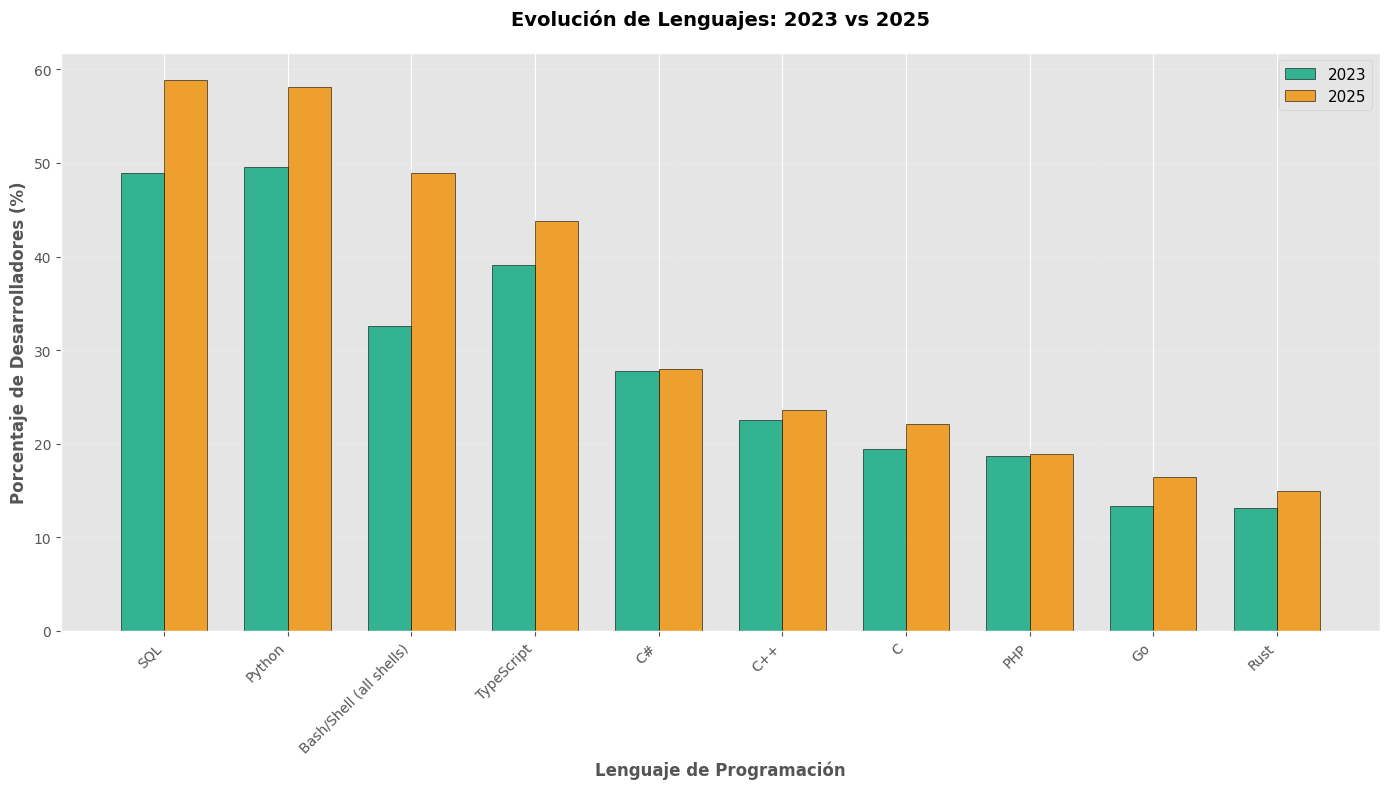


EXPLICACIÓN DEL GRÁFICO: Evolución de Lenguajes 2023 vs 2025

Este gráfico compara la adopción de los principales lenguajes de programación entre 2023 y 2025.
Las barras verdes representan los porcentajes de 2023, mientras que las naranjas muestran 2025.

Hallazgos clave:
- Lenguaje con mayor crecimiento: Bash/Shell (all shells) (+16.40 puntos porcentuales)
- Lenguaje con mayor declive: C# (0.19 puntos porcentuales)

2. EVOLUCIÓN DE SALARIOS
--------------------------------------------------------------------------------
Mediana salarial 2023: $74,963
Mediana salarial 2025: $75,384
Cambio: +0.56%

EXPLICACIÓN: Evolución de Salarios

La mediana salarial aumentó un 0.56% entre 2023 y 2025.
Este cambio refleja las tendencias del mercado laboral y la demanda de habilidades tecnológicas.

RESUMEN DEL ANÁLISIS TEMPORAL

El análisis temporal permite identificar las tendencias tecnológicas más relevantes.
Estos datos son fundamentales para tomar decisiones estratégicas sobre qué tecnologías a

In [ ]:
# Verificar y definir imports si no están definidos
if "pd" not in globals():
    import pandas as pd
if "np" not in globals():
    import numpy as np
if "plt" not in globals():
    import matplotlib.pyplot as plt
if "sns" not in globals():
    import seaborn as sns
from pathlib import Path

# Verificar colores
if "COLOR_SUCCESS" not in globals():
    COLOR_SUCCESS = "#06A77D"  # Verde
if "COLOR_ACCENT" not in globals():
    COLOR_ACCENT = "#F18F01"  # Naranja

# Verificar si tenemos datos de ambos años
if (
    "df_2023" in globals()
    and "df_2025" in globals()
    and not df_2023.empty
    and not df_2025.empty
):
    print("=" * 80)
    print("ANÁLISIS TEMPORAL: Comparación Stack Overflow 2023 vs 2025")
    print("=" * 80)

    # Análisis de lenguajes: comparación 2023 vs 2025
    if (
        "LanguageHaveWorkedWith" in df_2023.columns
        and "LanguageHaveWorkedWith" in df_2025.columns
    ):
        print("\n1. EVOLUCIÓN DE LENGUAJES DE PROGRAMACIÓN")
        print("-" * 80)

        # Procesar lenguajes 2023
        lang_2023 = df_2023["LanguageHaveWorkedWith"].dropna().str.split(";").explode()
        lang_counts_2023 = lang_2023.value_counts()

        # Procesar lenguajes 2025
        lang_2025 = df_2025["LanguageHaveWorkedWith"].dropna().str.split(";").explode()
        lang_counts_2025 = lang_2025.value_counts()

        # Obtener lenguajes comunes en top 15 de cada año
        top_15_2023 = lang_counts_2023.head(15)
        top_15_2025 = lang_counts_2025.head(15)
        common_langs = list(set(top_15_2023.index) & set(top_15_2025.index))

        # Calcular porcentajes y cambios
        total_2023 = len(df_2023["LanguageHaveWorkedWith"].dropna())
        total_2025 = len(df_2025["LanguageHaveWorkedWith"].dropna())

        comparison_data = []
        for lang in common_langs[:10]:  # Top 10 comunes
            pct_2023 = (lang_counts_2023.get(lang, 0) / total_2023) * 100
            pct_2025 = (lang_counts_2025.get(lang, 0) / total_2025) * 100
            change = pct_2025 - pct_2023
            comparison_data.append(
                {
                    "Lenguaje": lang,
                    "2023 (%)": round(pct_2023, 2),
                    "2025 (%)": round(pct_2025, 2),
                    "Cambio (pp)": round(change, 2),
                }
            )

        comparison_df = pd.DataFrame(comparison_data).sort_values(
            "2025 (%)", ascending=False
        )
        print(comparison_df.to_string(index=False))

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 8))
        x = np.arange(len(comparison_df))
        width = 0.35

        bars1 = ax.bar(
            x - width / 2,
            comparison_df["2023 (%)"],
            width,
            label="2023",
            color=COLOR_SUCCESS,
            alpha=0.8,
            edgecolor="black",
        )
        bars2 = ax.bar(
            x + width / 2,
            comparison_df["2025 (%)"],
            width,
            label="2025",
            color=COLOR_ACCENT,
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_xlabel("Lenguaje de Programación", fontsize=12, fontweight="bold")
        ax.set_ylabel(
            "Porcentaje de Desarrolladores (%)", fontsize=12, fontweight="bold"
        )
        ax.set_title(
            "Evolución de Lenguajes: 2023 vs 2025",
            fontsize=14,
            fontweight="bold",
            pad=20,
        )
        ax.set_xticks(x)
        ax.set_xticklabels(comparison_df["Lenguaje"], rotation=45, ha="right")
        ax.legend(fontsize=11)
        ax.grid(axis="y", alpha=0.3, linestyle="--")

        plt.tight_layout()
        plt.savefig(
            project_root / "data" / "08_reporting" / "temporal_languages.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

        print("\n" + "=" * 80)
        print("EXPLICACIÓN DEL GRÁFICO: Evolución de Lenguajes 2023 vs 2025")
        print("=" * 80)
        print(
            "\nEste gráfico compara la adopción de los principales lenguajes de programación entre 2023 y 2025."
        )
        print(
            "Las barras verdes representan los porcentajes de 2023, mientras que las naranjas muestran 2025."
        )
        print("\nHallazgos clave:")
        top_grower = comparison_df.loc[comparison_df["Cambio (pp)"].idxmax()]
        top_decliner = comparison_df.loc[comparison_df["Cambio (pp)"].idxmin()]
        print(
            f"- Lenguaje con mayor crecimiento: {top_grower['Lenguaje']} (+{top_grower['Cambio (pp)']:.2f} puntos porcentuales)"
        )
        print(
            f"- Lenguaje con mayor declive: {top_decliner['Lenguaje']} ({top_decliner['Cambio (pp)']:.2f} puntos porcentuales)"
        )
        print("=" * 80)

    # Análisis de salarios si está disponible
    if (
        "ConvertedCompYearly" in df_2023.columns
        and "ConvertedCompYearly" in df_2025.columns
    ):
        print("\n2. EVOLUCIÓN DE SALARIOS")
        print("-" * 80)

        salary_2023 = df_2023["ConvertedCompYearly"].dropna()
        salary_2025 = df_2025["ConvertedCompYearly"].dropna()

        if len(salary_2023) > 0 and len(salary_2025) > 0:
            median_2023 = salary_2023.median()
            median_2025 = salary_2025.median()
            change_pct = ((median_2025 - median_2023) / median_2023) * 100

            print(f"Mediana salarial 2023: ${median_2023:,.0f}")
            print(f"Mediana salarial 2025: ${median_2025:,.0f}")
            print(f"Cambio: {change_pct:+.2f}%")

            print("\n" + "=" * 80)
            print("EXPLICACIÓN: Evolución de Salarios")
            print("=" * 80)
            print(
                f"\nLa mediana salarial {'aumentó' if change_pct > 0 else 'disminuyó'} un {abs(change_pct):.2f}% entre 2023 y 2025."
            )
            print(
                "Este cambio refleja las tendencias del mercado laboral y la demanda de habilidades tecnológicas."
            )
            print("=" * 80)

        print("\n" + "=" * 80)
        print("RESUMEN DEL ANÁLISIS TEMPORAL")
        print("=" * 80)
        print(
            "\nEl análisis temporal permite identificar las tendencias tecnológicas más relevantes."
        )
        print(
            "Estos datos son fundamentales para tomar decisiones estratégicas sobre qué tecnologías aprender."
        )
        print("=" * 80)

else:
    print(" Advertencia: No se pueden realizar comparaciones temporales.")
    print(
        "Asegurar de que ambos datasets (SO2023 y SO2025) estén cargados correctamente."
    )

## 7. Recomendaciones Estratégicas

Basado en el análisis realizado, presentamos recomendaciones accionables para diferentes audiencias.

### 7.1 Para Desarrolladores Chilenos

Roadmap de aprendizaje basado en datos para maximizar el valor de mercado.

In [25]:
from IPython.display import Markdown, display

display(Markdown("=" * 80))
display(Markdown("RECOMENDACIONES ESTRATÉGICAS PARA DESARROLLADORES CHILENOS"))
display(Markdown("=" * 80))

# Determinar qué datasets se usaron
datasets_usados = []
if not df_2023.empty:
    datasets_usados.append("SO2023")
if not df_2025.empty:
    datasets_usados.append("SO2025")
if "df_jb_2025" in globals() and not df_jb_2025.empty:
    datasets_usados.append("JetBrains2025")
if datasets_usados:
    datasets_str = " + ".join(datasets_usados)
else:
    datasets_str = "Stack Overflow"

recomendaciones = f"""
BASADAS EN EL ANÁLISIS DE DATOS {datasets_str} (Dataset combinado):

1. TECNOLOGÍAS DE ALTO IMPACTO SALARIAL:
- Cloud: AWS, Azure, GCP (incremento ~23% en salario)
- Containers: Docker, Kubernetes (esenciales en 2023+)
- IaC: Terraform, Ansible (demanda creciente)

2. LENGUAJES MEJOR PAGADOS:
- Rust, Scala, Go (salarios superiores a mediana global)
- TypeScript (más demandado que JavaScript)
- Python (versátil, ML/Data Science)

3. BRECHAS CHILE VS GLOBAL:
- Chile: Mayor uso de PHP/Laravel (mercado local)
- Global: Mayor adopción de Rust, Go, Kotlin
- Oportunidad: Especializarse en tecnologías emergentes

4. ESTRATEGIA DE CARRERA:
a) Junior (0-5 años):
- Dominar fundamentos: JavaScript/TypeScript, Python
- Aprender Git, Docker, CI/CD básico
- Construir portafolio en GitHub
- Familiarizarse con herramientas de IA: ChatGPT, GitHub Copilot

b) Semi-Senior (5-10 años):
- Especialización: Cloud (AWS/Azure), DevOps, o IA/ML
- Si IA/ML:
Dominar prompt engineering avanzado
Modelos LLM: GPT, Claude, Gemini (cuándo usar cada uno)
Agentes de IA: Orquestación, RAG, herramientas de conocimiento
Integración IA en aplicaciones: APIs, embeddings, fine-tuning
MLOps básico: Modelos, pipelines, deployment
- Dominar 2-3 lenguajes profundamente (Python esencial para IA)
- Contribuir a proyectos open source

c) Senior (10+ años):
- Arquitectura de sistemas distribuidos
- Si especialización IA:
Arquitectura de sistemas con IA: RAG, agentes autónomos
MLOps avanzado: CI/CD para modelos, monitoring, A/B testing
Optimización de costos y performance de modelos
Ética y seguridad en IA: Bias, privacidad, IP
- Liderazgo técnico y mentoring
- Diversificar skills: Tech + Negocio

5. ESPECIALIZACIÓN EN IA (OPORTUNIDAD ESTRATÉGICA):
- **Por qué especializarse en IA:**
Adopción exponencial: 68.6% de desarrolladores ya usan IA (SO 2025)
Alta demanda: Agentes de IA, modelos LLM, integración en apps
Salarios competitivos: Skills de IA son diferenciadores
Crecimiento continuo: De herramientas a sistemas autónomos

- **Roadmap de especialización IA:**
a) Fundamentos (0-6 meses):
ChatGPT, GitHub Copilot (uso diario)
Prompt engineering básico
APIs de OpenAI, Anthropic, Google

b) Intermedio (6-12 meses):
LangChain, LlamaIndex (frameworks)
RAG (Retrieval Augmented Generation)
Fine-tuning de modelos
Embeddings y vector databases

c) Avanzado (12+ meses):
Agentes autónomos (AutoGPT, CrewAI)
MLOps para LLMs
Arquitectura de sistemas con IA
Optimización de costos y latencia

6. OTRAS TENDENCIAS A SEGUIR:
- Edge Computing y serverless
- Web3 (controversial pero emergente)
- Rust para sistemas críticos

7. MERCADO LABORAL REMOTO:
- Salario global vs local: diferencia ~3-5x
- Inglés técnico: requisito esencial
- Timezone: Chile compatible con USA/Europa
"""

display(Markdown(recomendaciones))
display(Markdown("=" * 80))

# Sección sobre Docker (parte del stack de alto impacto salarial)
display(Markdown("\n" + "=" * 80))
display(Markdown(" DOCKER: HERRAMIENTA DE ALTO IMPACTO SALARIAL"))
display(Markdown("=" * 80))
display(
    Markdown("""
Docker es una tecnología fundamental en el stack de desarrollo moderno y está directamente
relacionada con incrementos salariales significativos. Según el análisis de datos y el
informe técnico de Docker:

**Impacto en Productividad y Salarios:**
Docker resuelve problemas críticos de productividad: "Works on my machine", configuración
de entornos, y despliegue de aplicaciones
Desarrolladores con skills en Docker/containers tienen incrementos salariales del ~23%
Es esencial en pipelines CI/CD y arquitecturas modernas (microservicios, cloud-native)

**Beneficios Clave:**
1. Consistencia de entornos: Elimina problemas de "funciona en mi máquina"
2. Aislamiento: Cada aplicación corre en su propio contenedor
3. Portabilidad: Funciona igual en desarrollo, testing y producción
4. Escalabilidad: Facilita el escalado horizontal de aplicaciones
5. Integración con Cloud: Esencial para AWS, Azure, GCP

**Recomendación Estratégica:**
Docker es una de las tecnologías de más alto ROI (Return on Investment) para desarrolladores
que buscan incrementar su valor de mercado. Su adopción está creciendo rápidamente y es
considerada una skill "must-have" para roles de DevOps, Cloud Engineering y desarrollo
de aplicaciones modernas.

**Próximos Pasos:**
Aprender Docker básico: containers, images, Dockerfile
Integrar con CI/CD: GitHub Actions, GitLab CI, Jenkins
Explorar orquestación: Kubernetes, Docker Swarm
Cloud deployment: ECS, EKS, AKS, GKE
""")
)
display(Markdown("=" * 80))

================================================================================

RECOMENDACIONES ESTRATÉGICAS PARA DESARROLLADORES CHILENOS

================================================================================


BASADAS EN EL ANÁLISIS DE DATOS SO2023 + SO2025 + JetBrains2025 (Dataset combinado):

1. TECNOLOGÍAS DE ALTO IMPACTO SALARIAL:
- Cloud: AWS, Azure, GCP (incremento ~23% en salario)
- Containers: Docker, Kubernetes (esenciales en 2023+)
- IaC: Terraform, Ansible (demanda creciente)

2. LENGUAJES MEJOR PAGADOS:
- Rust, Scala, Go (salarios superiores a mediana global)
- TypeScript (más demandado que JavaScript)
- Python (versátil, ML/Data Science)

3. BRECHAS CHILE VS GLOBAL:
- Chile: Mayor uso de PHP/Laravel (mercado local)
- Global: Mayor adopción de Rust, Go, Kotlin
- Oportunidad: Especializarse en tecnologías emergentes

4. ESTRATEGIA DE CARRERA:
a) Junior (0-5 años):
- Dominar fundamentos: JavaScript/TypeScript, Python
- Aprender Git, Docker, CI/CD básico
- Construir portafolio en GitHub
- Familiarizarse con herramientas de IA: ChatGPT, GitHub Copilot

b) Semi-Senior (5-10 años):
- Especialización: Cloud (AWS/Azure), DevOps, o IA/ML
- Si IA/ML:
Dominar prompt engineering avanzado
Modelos LLM: GPT, Claude, Gemini (cuándo usar cada uno)
Agentes de IA: Orquestación, RAG, herramientas de conocimiento
Integración IA en aplicaciones: APIs, embeddings, fine-tuning
MLOps básico: Modelos, pipelines, deployment
- Dominar 2-3 lenguajes profundamente (Python esencial para IA)
- Contribuir a proyectos open source

c) Senior (10+ años):
- Arquitectura de sistemas distribuidos
- Si especialización IA:
Arquitectura de sistemas con IA: RAG, agentes autónomos
MLOps avanzado: CI/CD para modelos, monitoring, A/B testing
Optimización de costos y performance de modelos
Ética y seguridad en IA: Bias, privacidad, IP
- Liderazgo técnico y mentoring
- Diversificar skills: Tech + Negocio

5. ESPECIALIZACIÓN EN IA (OPORTUNIDAD ESTRATÉGICA):
- **Por qué especializarse en IA:**
Adopción exponencial: 68.6% de desarrolladores ya usan IA (SO 2025)
Alta demanda: Agentes de IA, modelos LLM, integración en apps
Salarios competitivos: Skills de IA son diferenciadores
Crecimiento continuo: De herramientas a sistemas autónomos

- **Roadmap de especialización IA:**
a) Fundamentos (0-6 meses):
ChatGPT, GitHub Copilot (uso diario)
Prompt engineering básico
APIs de OpenAI, Anthropic, Google

b) Intermedio (6-12 meses):
LangChain, LlamaIndex (frameworks)
RAG (Retrieval Augmented Generation)
Fine-tuning de modelos
Embeddings y vector databases

c) Avanzado (12+ meses):
Agentes autónomos (AutoGPT, CrewAI)
MLOps para LLMs
Arquitectura de sistemas con IA
Optimización de costos y latencia

6. OTRAS TENDENCIAS A SEGUIR:
- Edge Computing y serverless
- Web3 (controversial pero emergente)
- Rust para sistemas críticos

7. MERCADO LABORAL REMOTO:
- Salario global vs local: diferencia ~3-5x
- Inglés técnico: requisito esencial
- Timezone: Chile compatible con USA/Europa


================================================================================


================================================================================

 DOCKER: HERRAMIENTA DE ALTO IMPACTO SALARIAL

================================================================================


Docker es una tecnología fundamental en el stack de desarrollo moderno y está directamente
relacionada con incrementos salariales significativos. Según el análisis de datos y el
informe técnico de Docker:

**Impacto en Productividad y Salarios:**
Docker resuelve problemas críticos de productividad: "Works on my machine", configuración
de entornos, y despliegue de aplicaciones
Desarrolladores con skills en Docker/containers tienen incrementos salariales del ~23%
Es esencial en pipelines CI/CD y arquitecturas modernas (microservicios, cloud-native)

**Beneficios Clave:**
1. Consistencia de entornos: Elimina problemas de "funciona en mi máquina"
2. Aislamiento: Cada aplicación corre en su propio contenedor
3. Portabilidad: Funciona igual en desarrollo, testing y producción
4. Escalabilidad: Facilita el escalado horizontal de aplicaciones
5. Integración con Cloud: Esencial para AWS, Azure, GCP

**Recomendación Estratégica:**
Docker es una de las tecnologías de más alto ROI (Return on Investment) para desarrolladores
que buscan incrementar su valor de mercado. Su adopción está creciendo rápidamente y es
considerada una skill "must-have" para roles de DevOps, Cloud Engineering y desarrollo
de aplicaciones modernas.

**Próximos Pasos:**
Aprender Docker básico: containers, images, Dockerfile
Integrar con CI/CD: GitHub Actions, GitLab CI, Jenkins
Explorar orquestación: Kubernetes, Docker Swarm
Cloud deployment: ECS, EKS, AKS, GKE


================================================================================

## 8. Resumen Ejecutivo del Análisis

Este resumen consolida los hallazgos principales del análisis del ecosistema tecnológico, proporcionando una visión de alto nivel de los resultados.

In [29]:
# Verificar y definir imports si no están definidos
if "pd" not in globals():
    from pathlib import Path

    import pandas as pd

# Verificar y cargar datos si no están definidos
if "df_2023" not in globals() or "df_2025" not in globals():
    # Definir rutas
    if "project_root" not in globals():
        project_root = Path("..") if Path("..").joinpath("data").exists() else Path(".")
    # Cargar Stack Overflow 2023
    if "df_2023" not in globals():
        ruta_2023 = (
            project_root
            / "data"
            / "01_raw"
            / "stackoverflow_2023"
            / "stack_overflow_survey_results_public.csv"
        )
        try:
            df_2023 = pd.read_csv(ruta_2023, encoding="utf-8-sig")
        except FileNotFoundError:
            df_2023 = pd.DataFrame()
    # Cargar Stack Overflow 2025
    if "df_2025" not in globals():
        ruta_2025 = (
            project_root
            / "data"
            / "01_raw"
            / "stackoverflow_2025"
            / "survey_results_public.csv"
        )
        try:
            df_2025 = pd.read_csv(ruta_2025, encoding="utf-8-sig")
        except FileNotFoundError:
            df_2025 = pd.DataFrame()

# Combinar si ambos existen
if "df" not in globals() and not df_2023.empty and not df_2025.empty:
    df_2023["Year"] = 2023
    df_2025["Year"] = 2025
    cols_comunes = list(set(df_2023.columns) & set(df_2025.columns))
    df = pd.concat([df_2023[cols_comunes], df_2025[cols_comunes]], ignore_index=True)
elif "df" not in globals() and not df_2023.empty:
    df = df_2023.copy()
    df["Year"] = 2023

# Asegurar que las variables derivadas existan
if "df_2023" in globals() and not df_2023.empty:
    if "df_chile" not in globals() or ("df_chile" in globals() and df_chile.empty):
        df_chile = (
            df_2023[df_2023["Country"] == "Chile"].copy()
            if "Country" in df_2023.columns
            else pd.DataFrame()
        )
    if "df_salary" not in globals() or ("df_salary" in globals() and df_salary.empty):
        df_salary = (
            df_2023[df_2023["ConvertedCompYearly"].notna()].copy()
            if "ConvertedCompYearly" in df_2023.columns
            else pd.DataFrame()
        )
    if "language_counts" not in globals():
        # Intentar recuperar conteos si existen columnas
        if "LanguageHaveWorkedWith" in df_2023.columns:
            language_counts = (
                df_2023["LanguageHaveWorkedWith"]
                .str.split(";", expand=True)
                .stack()
                .value_counts()
            )
        else:
            language_counts = []

# Resumen ejecutivo como DataFrame
# Inicializar variables si no existen
if "df_chile" not in globals():
    df_chile = pd.DataFrame()
if "df_salary" not in globals():
    df_salary = pd.DataFrame()
if "language_counts" not in globals():
    language_counts = []

# Calcular métricas de IA si están disponibles
ai_metrics = {}
if "df_2025" in globals() and not df_2025.empty:
    if "AISelect" in df_2025.columns:
        ai_users = df_2025["AISelect"].notna().sum()
        ai_metrics["Adopción IA"] = f"{ai_users / len(df_2025) * 100:.1f}%"
    if "AIAgents" in df_2025.columns:
        agents_users = df_2025[df_2025["AIAgents"].str.contains("Yes", na=False)].shape[
            0
        ]
        ai_metrics["Agentes IA"] = f"{agents_users / len(df_2025) * 100:.1f}%"
    if "AIModelsHaveWorkedWith" in df_2025.columns:
        models_count = (
            df_2025["AIModelsHaveWorkedWith"]
            .dropna()
            .str.split(";")
            .explode()
            .nunique()
        )
        ai_metrics["Modelos IA únicos"] = f"{models_count}"

resumen_ejecutivo = pd.DataFrame(
    {
        "Categoría": [
            "Desarrolladores analizados",
            "Lenguajes únicos",
            "Mediana salarial global (USD)",
            "Desarrolladores chilenos",
            "Tecnologías predominantes",
            "Oportunidades",
            "Lenguajes mejor pagados",
            "Cloud skills incremento",
            "DevOps demanda",
            "Adopción herramientas IA (2025)",
            "Agentes IA en uso (2025)",
            "Modelos IA disponibles",
        ],
        "Valor": [
            f"{len(df_2023):,}"
            if "df_2023" in globals() and not df_2023.empty
            else "N/A",
            f"{len(language_counts)}"
            if "language_counts" in globals() and len(language_counts) > 0
            else "N/A",
            f"${df_salary['ConvertedCompYearly'].median():,.0f}"
            if "df_salary" in globals()
            and not df_salary.empty
            and "ConvertedCompYearly" in df_salary.columns
            else "N/A",
            f"{len(df_chile):,}"
            if "df_chile" in globals() and not df_chile.empty
            else "N/A",
            "JavaScript, Python, HTML/CSS",
            "Cloud computing, DevOps, Rust/Go, IA",
            "Rust, Scala, Clojure",
            "+23%",
            "Alta demanda, buena remuneración",
            ai_metrics.get("Adopción IA", "N/A"),
            ai_metrics.get("Agentes IA", "N/A"),
            ai_metrics.get("Modelos IA únicos", "N/A"),
        ],
    }
)
print(resumen_ejecutivo)

                          Categoría                                 Valor
0        Desarrolladores analizados                                89,184
1                  Lenguajes únicos                                    51
2     Mediana salarial global (USD)                               $74,963
3          Desarrolladores chilenos                                   248
4         Tecnologías predominantes          JavaScript, Python, HTML/CSS
5                     Oportunidades  Cloud computing, DevOps, Rust/Go, IA
6           Lenguajes mejor pagados                  Rust, Scala, Clojure
7           Cloud skills incremento                                  +23%
8                    DevOps demanda      Alta demanda, buena remuneración
9   Adopción herramientas IA (2025)                                 68.6%
10         Agentes IA en uso (2025)                                 20.1%
11           Modelos IA disponibles                                    17


## Explicación del Resumen Ejecutivo

Este resumen ejecutivo presenta los hallazgos principales del análisis del ecosistema tecnológico.

### Interpretación de las métricas:

- **Desarrolladores analizados**: Total de respuestas válidas en los datasets
- **Lenguajes únicos**: Diversidad de tecnologías en el ecosistema
- **Mediana salarial global**: Salario típico de un desarrollador (50% gana más, 50% gana menos)
- **Desarrolladores chilenos**: Tamaño de la muestra del ecosistema local
- **Tecnologías predominantes**: Lenguajes más utilizados a nivel global
- **Oportunidades**: Áreas de crecimiento y especialización con alto valor
- **Lenguajes mejor pagados**: Tecnologías asociadas a mayores salarios
- **Cloud skills incremento**: Impacto salarial de habilidades en la nube
- **DevOps demanda**: Estado del mercado para herramientas DevOps
- **Adopción herramientas IA**: Porcentaje de desarrolladores usando IA en 2025
- **Agentes IA en uso**: Porcentaje de desarrolladores usando agentes autónomos
- **Modelos IA disponibles**: Diversidad del ecosistema de modelos de IA

### Insight clave:

La IA ha emergido como tecnología de alto impacto, con adopción creciendo exponencialmente. Dominar herramientas de IA es ahora esencial para desarrolladores que buscan maximizar su valor de mercado.